In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import HTML

from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import copy

from ebov_data import *

if locations:
    pass
else:
    status()
    setFocusCountries(['SLE','LBR','GIN'])
    setColourMaps()
    loadData()

typeface='Helvetica Neue' ## set default matplotlib font and font size
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

path='<iframe style="border: 0; width: 400px; height: 460px;" src="https://bandcamp.com/EmbeddedPlayer/album=1406422575/size=large/bgcol=333333/linkcol=e99708/artwork=small/track=2364395925/transparent=true/" seamless><a href="http://romowerikoito.bandcamp.com/album/und-ina">Undeina by Romowe Rikoito</a></iframe>'
totalCaseCounts={x:sum(cases_byLocation[x].values()) for x in cases_byLocation.keys()}

countryCaseCounts={}
maxByCountry={}
for country in ['SLE','GIN','LBR']:
    countryCaseCounts[country]=np.vstack([[cases_byLocation[x][y] for y in dates] for x in cases_byLocation.keys() if location_to_country[x]==country])
    countryCaseCounts[country]=np.sum(countryCaseCounts[country],axis=0)
    maxByCountry[country]=max([totalCaseCounts[z] for z in totalCaseCounts.keys() if location_to_country[z]==country])

print '\nhighest case count in district:\n%s'%('\n'.join(['%s: %s'%(x,maxByCountry[x]) for x in maxByCountry.keys()]))

print '\ncase report dates: %s'%('\t'.join(dates))
print '\nnumber of districts in case report: %s'%(len(totalCaseCounts.keys()))
print '\ndate of most recent report: %s'%(dates[-1])

print 'Done!'
HTML(path)

Operating system:       Darwin (15.6.0)
Python version:         2.7.11
Numpy version:          1.11.1
Pandas version:         0.18.1
matplotlib version:      1.5.1
scipy version:          0.17.0

This notebook was last run on:
Thursday	2016-Oct-27	11:22	PDT

highest case count in district:
SLE: 4955
LBR: 2925
GIN: 784

case report dates: 2013-12-30	2014-01-06	2014-01-13	2014-01-20	2014-01-27	2014-02-03	2014-02-10	2014-02-17	2014-02-24	2014-03-03	2014-03-10	2014-03-17	2014-03-24	2014-03-31	2014-04-07	2014-04-14	2014-04-21	2014-04-28	2014-05-05	2014-05-12	2014-05-19	2014-05-26	2014-06-02	2014-06-09	2014-06-16	2014-06-23	2014-06-30	2014-07-07	2014-07-14	2014-07-21	2014-07-28	2014-08-04	2014-08-11	2014-08-18	2014-08-25	2014-09-01	2014-09-08	2014-09-15	2014-09-22	2014-09-29	2014-10-06	2014-10-13	2014-10-20	2014-10-27	2014-11-03	2014-11-10	2014-11-17	2014-11-24	2014-12-01	2014-12-08	2014-12-15	2014-12-22	2014-12-29	2015-01-05	2015-01-12	2015-01-19	2015-01-26	2015-02-02	2015-02-09	2015-02-16	

In [3]:
import baltic as bt ## use baltic, available at https://github.com/blab/baltic

tree_path=path_to_dropbox+'Sequences/Jun2016_1610_genomes/GLM/homogeneous/56_locations/jointInference/merged_western_area/Makona_1610_cds_ig.GLM.annot_merged_western_area.MCC.tre' 

tipFlag=False
tips={}
tipNum=0
for line in open(tree_path,'r'):
    l=line.strip('\n')

    cerberus=re.search('dimensions ntax=([0-9]+);',l.lower())
    if cerberus is not None:
        tipNum=int(cerberus.group(1))

    cerberus=re.search('tree TREE([0-9]+) = \[&R\] ',l)
    if cerberus is not None:
        treeString_start=l.index('(')
        ll=bt.tree() ## new instance of tree
        bt.make_tree(l[treeString_start:],ll) ## send tree string to make_tree function

    if tipFlag==True:
        cerberus=re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',l)
        if cerberus is not None:
            tips[cerberus.group(1)]=cerberus.group(2).strip('"').strip("'")
        elif ';' not in l:
            print 'tip not captured by regex:',l.replace('\t','')

    if 'translate' in l.lower():
        tipFlag=True
    if ';' in l:
        tipFlag=False

ll.treeStats() ## initial traversal, checks for stats
ll.sortBranches() ## traverses tree, sorts branches, draws tree
ll.renameTips(tips) ## renames tips from numbers to actual names

highestTip=max([decimalDate(x.name.strip("'").split('|')[-1]) for x in ll.Objects if isinstance(x,bt.leaf)])
print 'Highest tip: %.4f'%(highestTip)
for x in ll.Objects:
    x.absoluteTime=highestTip-ll.treeHeight+x.height

root_path=path_to_dropbox+'Sequences/Jun2016_1610_genomes/GLM/homogeneous/56_locations/jointInference/Makona_1610_cds_ig.GLM.filtered.tmrcas.txt' ## load tmrca distributions

burnin=10000000
for line in open(root_path,'r'):
    l=line.strip('\n').split('\t')
    if l[0]=='state':
        header=l
        param_idx={x:i for i,x in enumerate(header)}
        params=header[1:]
        rootHeights={x:[] for x in params}
    elif float(l[0])>=burnin:
        for param in params:
            rootHeights[param].append(float(l[param_idx[param]]))

print [np.mean(x) for x in rootHeights.values()]
print [np.median(x) for x in rootHeights.values()]
print [hpd(x,0.95) for x in rootHeights.values()]

print 'Done!'


Tree height: 1.807959
Tree length: 125.635476

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 3219 (1609 nodes and 1610 leaves)

Highest tip: 2015.8110
[2013.9692266509276, 2014.5441218912345, 2014.2903857641372]
[2013.9848710000001, 2014.5488559999999, 2014.291385]
[(2013.811014, 2014.100269), (2014.480108, 2014.604577), (2014.244979, 2014.332093)]
Done!


## Plot MCC tree with a map of West Africa

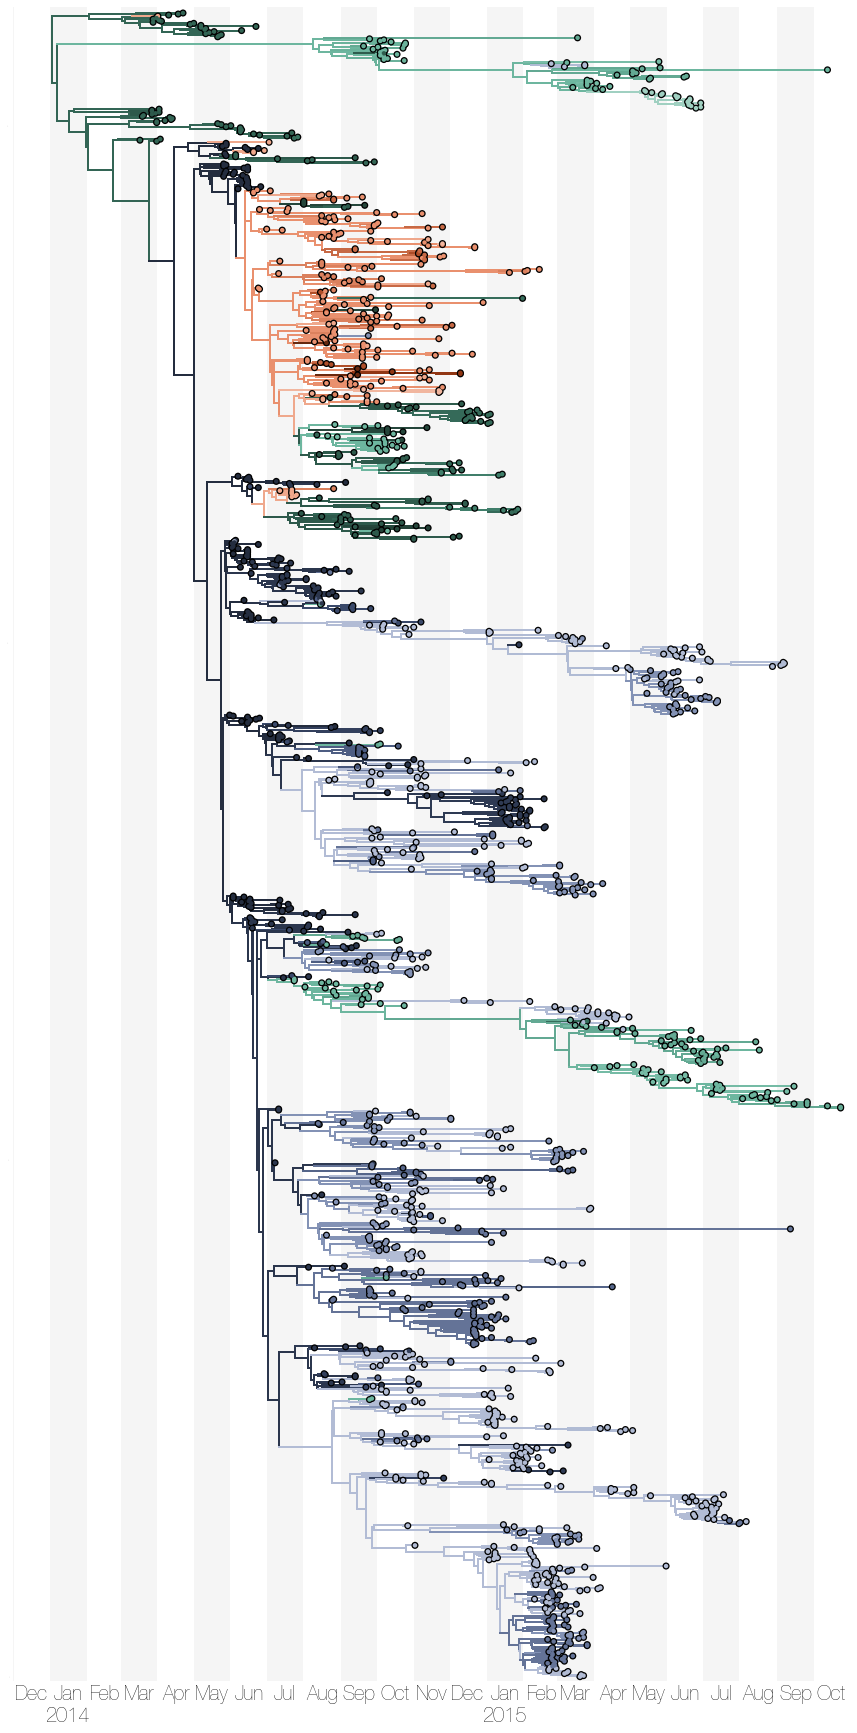

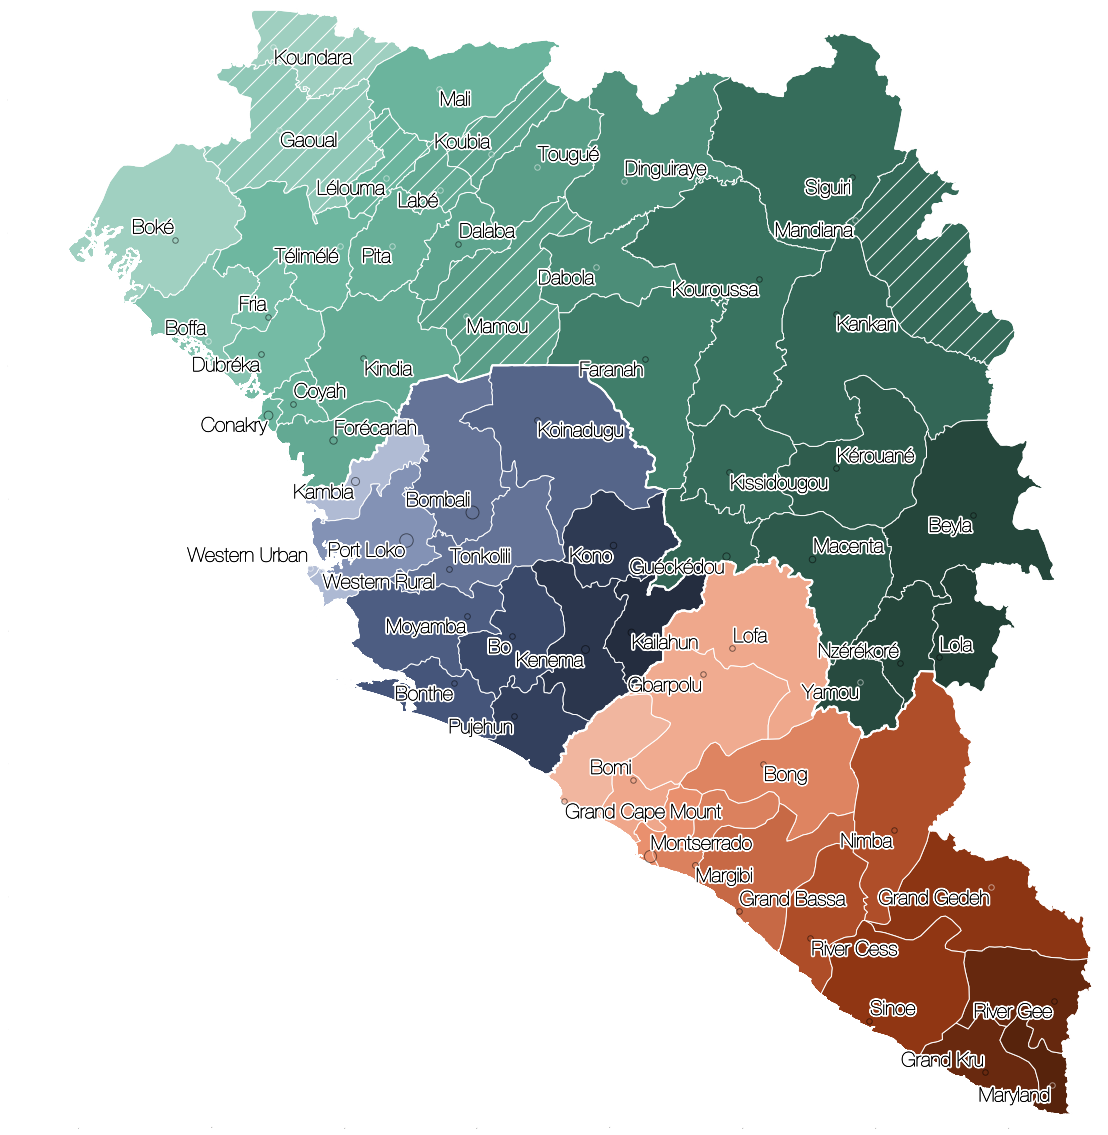

In [4]:
# fig,ax = plt.subplots(figsize=(15,320),facecolor='w') ## tree expanded vertically to allow outputing sequence labels
fig,ax = plt.subplots(figsize=(15,30),facecolor='w')

## name of districts in tree
# traitName='location'
traitName='location.states'

tipSize=20 ## tip circle radius
branchWidth=2 ## line width for branches

posteriorCutoff=0.0 ## posterior cutoff if collapsing tree

plot_tree=ll ## reference
# plot_tree=ll.collapseNodes('posterior',posteriorCutoff) ## collapse nodes lower than a given level of support

for k in plot_tree.Objects: ## iterate over branches in the tree
    location=k.traits[traitName] ## get inferred location of branch
    country=location_to_country[location] ## find country of location
    cmap=colours[country] ## fetch colour map for country
    c=cmap(normalized_coords[location]) ## get colour of location
    y=k.y ## get y coordinates
    yp=k.parent.y ## get parent's y coordinate
    
    x=k.absoluteTime ## x coordinate is absolute time
    xp=k.parent.absoluteTime ## get parent's absolute time
    
    if isinstance(k,bt.leaf): ## if tip...
        ax.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=100) ## put a circle at each tip
        ax.scatter(x,y,s=tipSize+30,facecolor='k',edgecolor='none',zorder=99)
        #ax.text(x+5/365.0,y,'%s'%(k.name),size=12,zorder=101,ha='left',va='center') ## uncomment to add tip labels (only use if tree is set up with a lot of vertical space)
        
    elif isinstance(k,bt.node): ## if node...
        yl=k.children[0].y ## get y coordinates of first and last child
        yr=k.children[-1].y
        
        if xp==0.0:
            xp=x

        ls='-'
        if k.traits['posterior']<posteriorCutoff: ## change to dotted line if posterior probability too low
            ls='--'
        ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,ls=ls,zorder=98) ## plot vertical bar connecting node to both its offspring
        
    ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98) ## plot horizontal branch to parent
    
ax.xaxis.tick_bottom() ## tick bottom
ax.yaxis.tick_left() ## tick left

xDates=['2013-%02d-01'%x for x in range(11,13)] ## create a timeline centered on each month
xDates+=['2014-%02d-01'%x for x in range(1,13)]
xDates+=['2015-%02d-01'%x for x in range(1,12)]

[ax.axvspan(decimalDate(xDates[x]),decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)] ## grey vertical bar every second month
ax.set_xticks([decimalDate(x)+1/24.0 for x in xDates]) ## x ticks in the middle of each month
ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates]) ## labels in mmm format unless January: then do YYYY-mmm

ax.spines['top'].set_visible(False) ## make axes invisible
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',labelsize=20,size=0) ## no axis labels visible except for timeline
ax.tick_params(axis='y',labelsize=0,size=0)

ax.set_xlim(decimalDate('2013-12-01'),decimalDate('2015-11-01')) ## bounds on axis limits
ax.set_ylim(-4,len(ll.leaves)+5)

plt.savefig(local_output+'tree.png',dpi=200,bbox_inches='tight') ## save to file
plt.savefig(local_output+'tree.pdf',dpi=200,bbox_inches='tight')
plt.show()

# ### Plot map
fig,ax2 = plt.subplots(figsize=(20,20),facecolor='w')

for i,loc in enumerate(locations): ## iterate over locations
    country=location_to_country[loc] ## identify country
    
    if country in required_countries: ## if country is to be plotted
        countryColour=colours[country] ## get colour map
        c=countryColour(normalized_coords[loc]) ## get colour based on location

        hatch=''
        if sum(cases_byLocation[loc].values())==0: ## hatching changes if location has no cases
            hatch='/'

        ax2.add_collection(PatchCollection(polygons[loc],facecolor=c,edgecolor='w',lw=1,zorder=1,hatch=hatch)) ## add location polygon collection

        lon,lat=popCentres[loc] ## get longitude/latitude of location's population centroid

        size=sum([k.length for k in ll.Objects if k.traits[traitName]==loc])**2 ## size of population centroid points depends on how long Ebola is inferred to have been in location

        ec='k'
        if size==0: ## white outline if lineages were never present
            ec='w'

        size=30+size
        ax2.scatter(lon,lat,size,facecolor=c,edgecolor=ec,lw=1,zorder=99,alpha=0.5) ## point at population centroid

        vas=['bottom','top'] ## define available text alignments and corrections for text positions
        has=['left','right']
        corrections=[0.01,-0.01]

        h=1 ## set default text alignment (right, top)
        v=1
        if textCorrection.has_key(loc): ## check if custom text positions are available
            h,v=textCorrection[loc]

        effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                 path_effects.Stroke(linewidth=0.5, foreground='black')] ## black text, white outline

        ax2.text(lon+corrections[h],lat+corrections[v]*1.5,r'%s'%map_to_actual[loc],size=20,
                 va=vas[v],ha=has[h],alpha=1.0,path_effects=effects,zorder=100) ## plot district names at population centres, with corrections so as not to obscure it

for l,local_border in enumerate(global_border): ## plot the international borders
    ax2.plot(column(local_border,0),column(local_border,1),lw=2,color='w',zorder=97,label='%d_border'%(l))

ax2.set_aspect(1) ## we're close to the equator - enforce 1:1 aspect for longitude and latitude
ax2.spines['top'].set_visible(False) ## hide axes
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.tick_params(axis='x',labelsize=0,size=0) ## no visible axis labels
ax2.tick_params(axis='y',labelsize=0,size=0)

ax2.set_ylim(ylimits) ## bounds on plot
ax2.set_xlim(xlimits)

# plt.savefig(local_output+'tree_legend.png',dpi=300,bbox_inches='tight') ## save to file
# plt.savefig(local_output+'tree_legend.pdf',dpi=300,bbox_inches='tight')

plt.show()

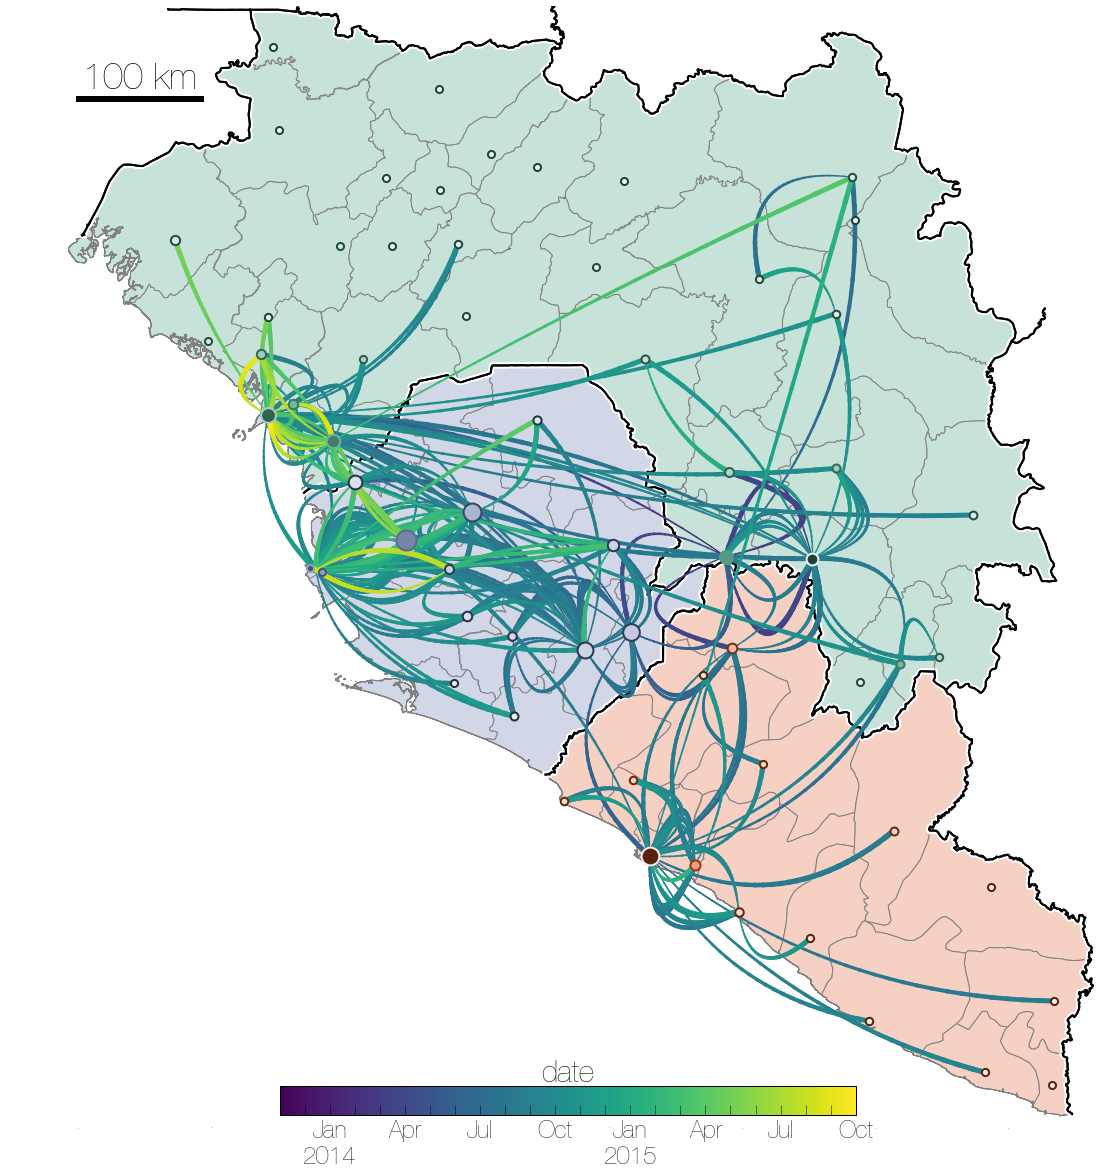

In [5]:
fig,ax = plt.subplots(figsize=(20,20),facecolor='w')

traitName='location.states' ## name of locations trait in tree

travel_lineages=sorted([k for k in ll.Objects if k.parent!=ll.root and k.traits[traitName]!=k.parent.traits[traitName]],key=lambda x:x.absoluteTime) ## only interested in lineages travelling

xDates=['2013-%02d-01'%x for x in range(11,13)] ## create timeline
xDates+=['2014-%02d-01'%x for x in range(1,13)]
xDates+=['2015-%02d-01'%x for x in range(1,11)]

heights=[k.absoluteTime for k in travel_lineages] ## get absolute times of each branch in the tree
height_normalization=create_normalization([decimalDate(xDates[0]),decimalDate(xDates[-1])],0.0,1.0) ## create a normalization based on timeline, where earliest day is 0.0 and latest is 1.0

cmap=mpl.cm.get_cmap('viridis') ## colour map

for k in travel_lineages: ## iterate through lineages which have switched location
    locA=k.traits[traitName] ## get location of current lineage
    locB=k.parent.traits[traitName] ## get location of where it came from
    
    oriX,oriY=popCentres[locA] ## get population centroid coordinates
    desX,desY=popCentres[locB]
    
    normalized_height=height_normalization(k.absoluteTime) ## normalize heights of lineages
    normalized_parent_height=height_normalization(k.parent.absoluteTime)
    
    distance=math.sqrt(math.pow(oriX-desX,2)+math.pow(oriY-desY,2)) ## find travelling distance
    
    adjust_d=1-2*normalized_height+1/float(distance)**0.1-0.5 ## position Bezier curve control point according to an arbitrary function
    
    n=Bezier_control((oriX,oriY),(desX,desY),adjust_d) ## control point perpendicular to midway between point A and B at a distance adjust_d
    
    curve=Bezier([(oriX,oriY),n,(desX,desY)],0.0,1.0,num=30) ## get Bezier line coordinates
    
    for i in range(len(curve)-1): ## iterate through Bezier curve coordinates, alter colour according to height
        x1,y1=curve[i]
        x2,y2=curve[i+1]
        frac=i/float(len(curve)) ## fraction along line
        
        ax.plot([x1,x2],[y1,y2],lw=1+4*(1-frac),color=cmap(normalized_parent_height+(normalized_height-normalized_parent_height)*(1-frac)),zorder=int(normalized_height*10000)) ## curve tapers and changes colour

for i,loc in enumerate(locations): ## iterate over locations
    country=location_to_country[loc] ## get country
    
    if country in required_countries: ## if country required
        countryColour=colours[country] ## get colour map
        c=countryColour(totalCaseCounts[loc]/float(maxByCountry[country])) ## colour proportional to cases

        ax.add_collection(PatchCollection(polygons[loc],facecolor=countryColour(0.1),edgecolor='grey',lw=1,zorder=1)) ## polygon colour pale

        lon,lat=popCentres[loc] ## population centroid coordinates

        size=[k.traits[traitName] for k in ll.Objects].count(loc) ## circle size proportional to branches in location
        size=50+size
        ax.scatter(lon,lat,size,facecolor=c,edgecolor=desaturate(countryColour(1-(totalCaseCounts[loc]/float(maxByCountry[country]))),1.0),lw=2,zorder=200000) ## plot circle, edge coloured inversely from main colour

ycoord=np.mean([4.3,12.7]) ## add bar to indicate distance
legend_y=12.0
legend_x1=-15
legend_x2=-14.08059

ax.plot([legend_x1,legend_x2],[legend_y,legend_y],color='k',lw=6)
ax.text(np.mean([legend_x1,legend_x2]),legend_y+0.04,'%.0f km'%metricDistance((legend_x1,legend_y),(legend_x2,legend_y)),size=36,va='bottom',ha='center')

colorbarTextSize=30 ## add colourbars - colours are log-normalized
colorbarTickLabelSize=24
colorbarWidth=0.02
colorbarHeight=0.4
colorbarIncrement=0.08

ax2 = fig.add_axes([colorbarIncrement*4, 0.13, colorbarHeight, colorbarWidth]) ## add dummy axes

mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=mpl.colors.Normalize([decimalDate(xDates[0]),decimalDate(xDates[-1])]),orientation='horizontal')
ax2.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=len(xDates))) ## add colour bar to axes

xaxis_labels=['' if (int(x.split('-')[1])+2)%3!=0 else convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates] ## month if month+2 is divisible by 3 (January, April, July, October)
    
ax2.set_xticklabels(xaxis_labels) ## set colour bar tick labels
ax2.xaxis.set_label_position('top') ## colour bar label at the top
ax2.set_xlabel('date',color='k',size=colorbarTextSize) ## colour bar label is "date"
ax2.tick_params(labelcolor='k',size=10,labelsize=colorbarTickLabelSize) ## adjust axis parameters

for l,local_border in enumerate(global_border): ## plot the international borders
    ax.plot(column(local_border,0),column(local_border,1),lw=2,color='k',zorder=97)
    ax.plot(column(local_border,0),column(local_border,1),lw=6,color='w',zorder=96)

ax.set_aspect('equal') ## aspect of 1 because we're close to the equator
ax.spines['top'].set_visible(False) ## invisible axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(labelsize=0,size=0) ## invisible axis labels

ax.set_ylim(ylimits) ## bounds on plot
ax.set_xlim(xlimits)

# plt.savefig(local_output+'geoTree.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'geoTree.pdf',dpi=300,bbox_inches='tight')
plt.show()

Number of cells to plot: 9
0 0 ['2013-12-30', '2014-01-06', '2014-01-13', '2014-01-20', '2014-01-27', '2014-02-03', '2014-02-10', '2014-02-17', '2014-02-24', '2014-03-03']
1 10 ['2014-03-10', '2014-03-17', '2014-03-24', '2014-03-31', '2014-04-07', '2014-04-14', '2014-04-21', '2014-04-28', '2014-05-05', '2014-05-12']
2 20 ['2014-05-19', '2014-05-26', '2014-06-02', '2014-06-09', '2014-06-16', '2014-06-23', '2014-06-30', '2014-07-07', '2014-07-14', '2014-07-21']
3 30 ['2014-07-28', '2014-08-04', '2014-08-11', '2014-08-18', '2014-08-25', '2014-09-01', '2014-09-08', '2014-09-15', '2014-09-22', '2014-09-29']
4 40 ['2014-10-06', '2014-10-13', '2014-10-20', '2014-10-27', '2014-11-03', '2014-11-10', '2014-11-17', '2014-11-24', '2014-12-01', '2014-12-08']
5 50 ['2014-12-15', '2014-12-22', '2014-12-29', '2015-01-05', '2015-01-12', '2015-01-19', '2015-01-26', '2015-02-02', '2015-02-09', '2015-02-16']
6 60 ['2015-02-23', '2015-03-02', '2015-03-09', '2015-03-16', '2015-03-23', '2015-03-30', '2015-04

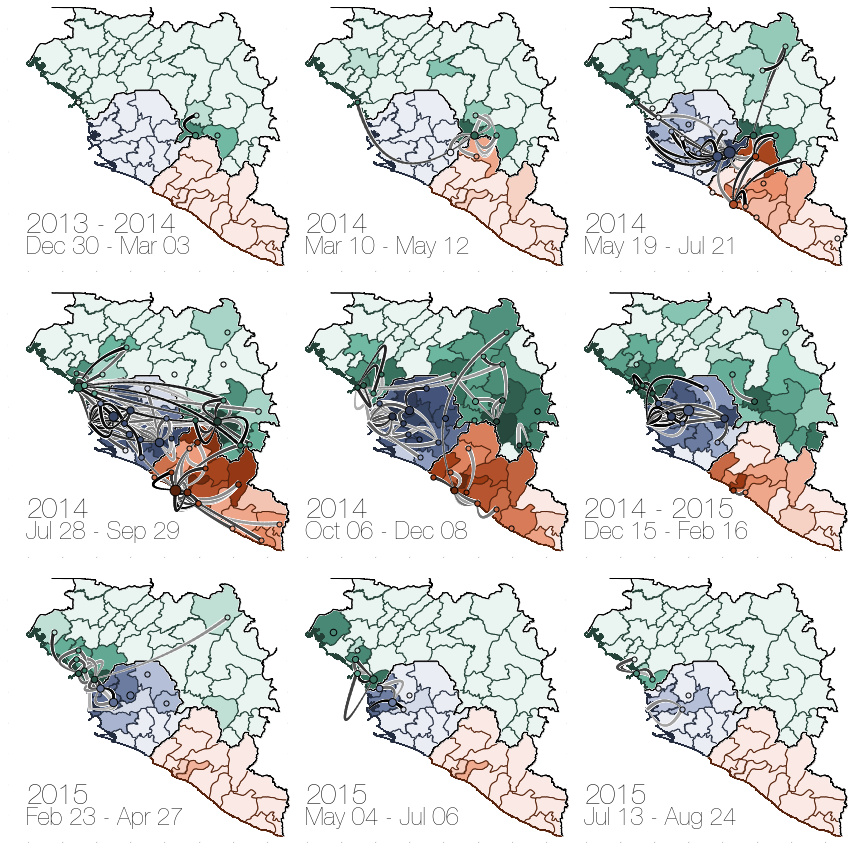

In [6]:
normCmap=make_cmap([mpl.cm.Greys(x) for x in np.linspace(0.4,1.0,256)])

# traitName='location'
traitName='location.states'
travel_lineages=sorted([k for k in ll.Objects if k.parent!=ll.root and k.traits[traitName]!=k.parent.traits[traitName]],key=lambda x:x.absoluteTime)

partitioning=10 ## choose how many epi weeks to lump together
dates2=dates[:dates.index('2015-08-31')] ## only plot up to end of August

dateRange=range(0,len(dates2),partitioning) ## indices for lumping epiweeks

lumpy_maxima={country:0 for country in required_countries} ## will contain maximum number of cases in any given epiweek lump, split by country
for country in required_countries: ## iterate over countries
    for d,idx in enumerate(dateRange): ## iterate over lumps of epiweeks
        epiweeks=dates2[idx:idx+partitioning] ## fetch epiweeks
        
        for loc in cases_byLocation.keys(): ## iterate over locations
            c=location_to_country[loc] ## find country
            if c==country: ## if country matches
                case_lump=sum([cases_byLocation[loc][week] for week in epiweeks]) ## lump cases across epiweeks
                if case_lump>=lumpy_maxima[country]: ## if current location has more cases across epiweeks it becomes new maximum
                    lumpy_maxima[country]=case_lump
    
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cols=3 ## number of columns
N=len(dateRange) ## number of individual maps
rows=int(N/cols)+1 ## find the number of rows required to plot all lumps

print 'Number of cells to plot: %d'%(N)

scale=5 ## fig size scalar
plt.figure(figsize=(cols*scale,rows*scale),facecolor='w')

gs = gridspec.GridSpec(rows, cols,hspace=0.1,wspace=0.0,width_ratios=[1 for c in range(cols)],height_ratios=[1 for r in range(rows)]) ## gridspec for figure grid

epiweek_stepsize=decimalDate(dates2[1])-decimalDate(dates2[0]) ## find how long an epiweek is, should be around 7/365.0

timemin='2013-12-01' ## start time
timemax='2015-11-01' ## end time

height_normalization=create_normalization([decimalDate(timemin),decimalDate(timemax)],0.0,1.0) ## create height normalization where 0.0 is earliest and 1.0 is latest

for d,idx in enumerate(dateRange): ## iterate over epiweek lumps
    epiweeks=dates2[idx:idx+partitioning] ## fetch epiweeks in lump
    
    first=epiweeks[0]
    last=epiweeks[-1]
    
    treeStart=decimalDate(epiweeks[0]) ## tree starts at the beginning of the first epiweek in lump
    treeEnd=decimalDate(epiweeks[-1])+epiweek_stepsize ## finishes at the end of the last epiweek
    
    print d,idx,epiweeks
    
    cases_in_lump={loc:sum([cases_byLocation[loc][week] for week in epiweeks]) for loc in cases_byLocation.keys()} ## identify how many cases are in lump
    
    row=int(d/cols) ## current row is *quotient* when dividing lump index by number of available columns
    
    if row==0: ## current column is *remainder* when dividing lump index by number of available columns
        col=d
    else:
        col=d%cols

    height_normalization=create_normalization([treeStart,treeEnd],0.0,1.0) ## normalize heights to be within [0.0,1.0]
    
    ax = plt.subplot(gs[row, col]) ## fetch axes at the right cell in the grid
    
    for k in travel_lineages: ## iterate over travelling lineages
        if treeStart<np.mean([k.parent.absoluteTime,k.absoluteTime])<=treeEnd: ## if travelling lineage's mid-point is within interval - plot it
            locA=k.traits[traitName] ## end location
            locB=k.parent.traits[traitName] ## start location

            oriX,oriY=popCentres[locA]
            desX,desY=popCentres[locB]

            normalized_height=height_normalization(k.absoluteTime) ## normalize time of lineage
            normalized_parent_height=height_normalization(k.parent.absoluteTime)

            distance=math.sqrt(math.pow(oriX-desX,2)+math.pow(oriY-desY,2))
            adjust_d=1-2*normalized_height+1/float(distance)**0.1-0.5
            n=Bezier_control((oriX,oriY),(desX,desY),adjust_d)
            curve=Bezier([(oriX,oriY),n,(desX,desY)],0.0,1.0,num=30)

            midpoint=np.mean([normalized_parent_height,normalized_height])
            
            for i in range(len(curve)-1): ## iterate through Bezier curve coordinates, alter colour according to height
                x1,y1=curve[i]
                x2,y2=curve[i+1]
                frac=1-(i/float(len(curve)))

                ax.plot([x1,x2],[y1,y2],lw=1+2*frac,color=normCmap(midpoint),zorder=int(normalized_height*10000))
                ax.plot([x1,x2],[y1,y2],lw=1+4*frac,color='w',zorder=int(normalized_height*10000)-1)
            
    for i,loc in enumerate(locations):
        country=location_to_country[loc]
        
        if country in required_countries:
            countryColour=colours[country]
            c=countryColour(np.log10(cases_in_lump[loc])/float(np.log10(lumpy_maxima[country])))

            ax.add_collection(PatchCollection(polygons[loc],facecolor=c,edgecolor=countryColour(1.0),lw=1,zorder=1))

            lon,lat=popCentres[loc]

            size=[k.traits[traitName] for k in ll.Objects if k.parent.absoluteTime<=treeEnd and treeStart<=k.absoluteTime].count(loc)/2.0

            if size>0:
                size+=25
            ax.scatter(lon,lat,size,facecolor=c,edgecolor='k',lw=1,zorder=200000)
        
    ax.text(0.05,0.13,'%s'%(' - '.join(unique([first.split('-')[0],last.split('-')[0]]))),size=28,transform=ax.transAxes)
    ax.text(0.05,0.05,'%s - %s'%(convertDate(first,'%Y-%m-%d','%b %d'),convertDate(last,'%Y-%m-%d','%b %d')),size=24,transform=ax.transAxes)

    for l,local_border in enumerate(global_border):
        ax.plot(column(local_border,0),column(local_border,1),lw=1,color='k',zorder=97,label='%d_border'%(l))
        ax.plot(column(local_border,0),column(local_border,1),lw=2,color='w',zorder=96)
        
    colorbarTextSize=30
    colorbarTickLabelSize=20
    colorbarWidth=0.02
    colorbarHeight=0.35

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(labelsize=0,size=0)

    ax.set_ylim(ylimits)
    ax.set_xlim(xlimits)

# plt.savefig(local_output+'spatial.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'spatial.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [7]:
branchWidth=2
tipSize=30

traitName='location.states'
# traitName='location'
ll.root.traits[traitName]='reservoir' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch
ll.root.y=0
ll.root.x=ll.Objects[0].absoluteTime

location_to_country['reservoir']='?'
normalized_coords['reservoir']=1.0

tree_strings={'SLE':[],'GIN':[],'LBR':[]} ## will contain tree string derived from introductions into each country
country_trees={'SLE':[],'GIN':[],'LBR':[]}

subtree_sizes={loc:[] for loc in locations}
subtree_sizes['WesternArea']=[]
subtree_lengths={loc:[] for loc in locations}
subtree_lengths['WesternArea']=[]

output_subtrees=open(local_output+'subtrees.txt','w')
print>>output_subtrees,'location\tcountry\torigin location\torigin country\tclade TMRCA\tparent TMRCA\tclade size\tpersistence\ttree string'


for l in sorted(ll.Objects,key=lambda x:x.height): ## iterate over branches
    k=l
    kp=l.parent
    
    kloc=k.traits[traitName]
    if k.parent.traits.has_key(traitName): ## get current branch's country and its parent's country
        kploc=kp.traits[traitName]
        kpc=location_to_country[kploc]
    else:
        kploc='reservoir'
        kpc='reservoir'

    kc=location_to_country[kloc]
    
    if kloc!=kploc: ## if locations don't match
        if isinstance(k,bt.node): ## and dealing with node
            if [ch.traits[traitName] for ch in k.children].count(kloc)>0: ## if at least one child is in the same location as its parent
                loc_subtree=copy.deepcopy(ll.traverseWithinTrait(k,traitName)) ## traverse from current branch until the very end
                loc_leaves=[x.name for x in loc_subtree if isinstance(x,bt.leaf)] ## get number of leaves in resulting subtree
                subtree_sizes[kloc].append(len(loc_leaves)) ## remember subtree size
        else: ## dealing with leaf...
            subtree_sizes[kloc].append(1) ## subtree of size 1
            
    if kc!=kpc: ## if countries don't match
#     if kloc!=kploc and kc==kpc: ## if locations don't match but are within the same country
#     if kloc!=kploc: ## if locations don't match
        proceed=False ## assume we still can't proceed forward
        
        if isinstance(k,bt.leaf): ## if dealing with a leaf - proceed
            N_children=1
            proceed=True
        else:
            N_children=len(k.leaves)
            if [location_to_country[ch.traits[traitName]] for ch in k.children].count(kc)>0: ## proceed if at least one child is in the same country i.e. not dealing with a hanging internal node ## if countries don't match
#             if [ch.traits[traitName] for ch in k.children].count(kloc)>0: ## if locations don't match
                proceed=True
        
        subtree=copy.deepcopy(ll.traverseWithinTrait(k,traitName,location_to_country)) ## subtree is a deep-copied list of objects traversed from a node that switched traits, as long as traversal is taking place within the same trait, this version is for countries
#         subtree=copy.deepcopy(ll.traverseWithinTrait(k,traitName)) ## this version is for locations
        subtree_leaves=[x.name for x in subtree if isinstance(x,bt.leaf)]
        
        if len(subtree_leaves)>0 and proceed==True: ## if at least one valid tip and no hanging nodes
            print '%s (%s) to %s (%s) jump (ancestor %d, %d leaves in full tree, now has %d)'%(kpc,kploc,kc,kloc,k.index,N_children,len(subtree_leaves))
            
            subtree_lengths[kloc].append((k.length*0.5)+max([decimalDate(x.strip("'").split('|')[-1]) for x in subtree_leaves])-k.absoluteTime) ## remember time from mid-point to last tip (subtree height)

            
            ## commented out bit plots the subtree in its unrepaired state
#             fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(15,1+np.log10(len(subtree))*5),squeeze=True)

#             node_times=[w.absoluteTime for w in subtree if w.absoluteTime!=None]
#             node_times+=[subtree[0].absoluteTime-subtree[0].length]
#             node_ys=[w.y for w in subtree]
            
#             ## plot uncorrected subtree in first subplot
#             for w in subtree:
#                 location=w.traits[traitName]
#                 country=location_to_country[location]
#                 cmap=countryColours[country]
#                 c=cmap(normalized_coords[location])

#                 y=w.y
#                 x=w.absoluteTime

#                 ## the root of the complete tree has no parent
#                 if w.parent==None:
#                     print w.index
#                 else:
#                     xp=w.parent.absoluteTime
#                     yp=w.parent.y

#                     if isinstance(w,leaf):
#                         ax1.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=100)
#                         ax1.scatter(x,y,s=tipSize+30,facecolor='k',edgecolor='k',zorder=99)
#                         ax1.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98)

#                     elif isinstance(w,node):
#                         yl=w.children[0].y
#                         yr=w.children[-1].y

#                         ax1.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98)
#                         ax1.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=98)

#                         if sum([1 if ch in subtree else 0 for ch in w.children])<len(w.children):
#                             ax1.text(x+0.001,y,'%d'%(w.index),va='center',ha='left',size=14,zorder=1000)

#             xlabels=['2013-%02d-01'%(d) for d in range(12,13)]
#             xlabels+=['2014-%02d-01'%(d) for d in range(1,13)]
#             xlabels+=['2015-%02d-01'%(d) for d in range(1,12)]
#             ax1.set_xticks(map(decimalDate,xlabels))
#             #ax1.set_xticklabels(xlabels)

#             #ax1.set_ylim(-0.5,len(subtree)/2+0.5)
#             ax1.set_xlim(min(node_times)-0.02,max(node_times)+0.02)
            #plt.show()
            
            while sum([len(nd.children)-sum([1 if ch in subtree else 0 for ch in nd.children]) for nd in subtree if isinstance(nd,bt.node) and nd.index!='Root'])>0: ## keep removing nodes as long as there are nodes with children that are not entirely within subtree
                for nd in sorted([q for q in subtree if isinstance(q,bt.node)],key=lambda x:(sum([1 if ch in subtree else 0 for ch in x.children]),x.height)): ## iterate over nodes in subtree, starting with ones that have fewest valid children and are more recent
                    
                    child_status=[1 if ch in subtree else 0 for ch in nd.children] ## check how many children of current node are under the right trait value
                    
                    if sum(child_status)<2 and nd.index!='Root': ## if less than 2 children in subtree (i.e. not all children are under the same trait state)
                        #print 'removing: %d, children in: %s'%(nd.index,[location_to_country[ch.traits[traitName]] for ch in nd.children])
                        grand_parent=nd.parent ## fetch grandparent of node to be removed
                        grand_parent.children.remove(nd) ## remove node from its parent's children

                        if sum(child_status)==0: ## node has no valid children - current grandparent will be removed on next iteration, since it will only have one child
                            pass
                        else: ## at least one child is still valid - reconnect the one valid child to grandparent
                            child=nd.children[child_status.index(1)] ## identify the valid child
                            child.parent=grand_parent ## child's parent is now its grandparent
                            grand_parent.children.append(child) ## child is now child of grandparent
                            child.length+=nd.length ## child's length now includes it's former parent's length
                        subtree.remove(nd) ## remove node from subtree
            
            if len(subtree)>0: ## only proceed if there's at least one tip in the subtree
                local_tree=bt.tree() ## create a new tree object where the subtree will be

                local_tree.Objects=subtree ## assign branches to new tree object

                local_tree.root.children.append(subtree[0]) ## connect tree object's root with subtree
                subtree[0].parent=local_tree.root ## subtree's root's parent is tree object's root
                local_tree.root.absoluteTime=subtree[0].absoluteTime-subtree[0].length ## root's absolute time is subtree's root time

                local_tree.sortBranches() ## sort branches, draw small tree

                local_tree.root.x=local_tree.Objects[0].x ## assign coordinates to subtree
                local_tree.root.y=local_tree.Objects[0].y

                tree_strings[kc].append(local_tree.toString()) ## remember subtree string, subtree object itself
                country_trees[kc].append((kploc,local_tree))
                
                mostRecentSubtreeTip=max([decimalDate(x.strip("'").split('|')[-1]) for x in subtree_leaves])
                persistence=mostRecentSubtreeTip-k.absoluteTime
                ancestorTime=k.parent.absoluteTime
                cladeTMRCA=k.absoluteTime
                originCountry=kpc
                originLoc=kploc
                cladeSize=len(subtree_leaves)

                subtreeString=local_tree.toString()

                print>>output_subtrees,'%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s'%(kc,kloc,kpc,kploc,cladeTMRCA,ancestorTime,len(subtree_leaves),persistence,subtreeString)
                
                ## commented out bit plots subtree after it's repaired
                ## get colour of the (sub)tree's origin
    #             oriC=desaturate(countryColours[kpc](0.6),0.8)
    #             if local_tree.Objects[0].absoluteTime==None:
    #                 oriX=local_tree.Objects[0].absoluteTime
    #                 oriY=local_tree.Objects[0].y
    #             else:
    #                 oriX=local_tree.Objects[0].parent.absoluteTime
    #                 oriY=local_tree.Objects[0].y

                ## plot circle at the base of each subtree
    #             ax2.scatter(oriX,oriY,120,facecolor=oriC,edgecolor='w',lw=2,zorder=200)

    #             node_times=[w.absoluteTime for w in subtree if w.absoluteTime!=None]
    #             node_times+=[subtree[0].absoluteTime-subtree[0].length]
    #             node_ys=[w.y for w in subtree]

    #             ## plot fixed subtree onto secondary plot
    #             for w in subtree:
    #                 location=w.traits[traitName]
    #                 country=location_to_country[location]
    #                 cmap=countryColours[country]
    #                 c=cmap(normalized_coords[location])

    #                 y=w.y
    #                 x=w.absoluteTime

    #                 ## the root of the complete tree has no parent
    #                 if w.parent==None:
    #                     print w.index
    #                 else:
    #                     xp=w.parent.absoluteTime
    #                     yp=w.parent.y

    #                     if isinstance(w,leaf):
    #                         ax2.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98)

    #                         ax2.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=100)
    #                         ax2.scatter(x,y,s=tipSize+30,facecolor='k',edgecolor='k',zorder=99)

    #                     elif isinstance(w,node):
    #                         yl=w.children[0].y
    #                         yr=w.children[-1].y

    #                         ax2.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98)
    #                         ax2.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=98)

    #             ax2.set_xticks(map(decimalDate,xlabels))
    #             ax2.set_xticklabels(xlabels,rotation=90)

    #             #ax2.set_ylim(-0.5,len(subtree)/2+0.5)
    #             ax2.set_xlim(min(node_times)-0.02,max(node_times)+0.02)
    #             plt.show()
output_subtrees.close()
print 'Done!'

? (reservoir) to GIN (Gueckedou) jump (ancestor 0, 1610 leaves in full tree, now has 118)
GIN (Gueckedou) to LBR (Lofa) jump (ancestor 2126440, 1 leaves in full tree, now has 1)
GIN (Gueckedou) to SLE (Kailahun) jump (ancestor 115873, 1485 leaves in full tree, now has 1005)
SLE (Kailahun) to GIN (Gueckedou) jump (ancestor 115877, 7 leaves in full tree, now has 7)
SLE (Kailahun) to GIN (Gueckedou) jump (ancestor 125852, 1 leaves in full tree, now has 1)
SLE (Kailahun) to LBR (Lofa) jump (ancestor 129178, 3 leaves in full tree, now has 3)
SLE (Kailahun) to LBR (Montserrado) jump (ancestor 1696080, 277 leaves in full tree, now has 196)
SLE (Kailahun) to LBR (Lofa) jump (ancestor 148757, 50 leaves in full tree, now has 9)
SLE (Kailahun) to LBR (Lofa) jump (ancestor 141270, 1 leaves in full tree, now has 1)
SLE (Kenema) to GIN (Conakry) jump (ancestor 1475771, 126 leaves in full tree, now has 107)
LBR (Lofa) to GIN (Macenta) jump (ancestor 180018, 26 leaves in full tree, now has 26)
LBR (Lo

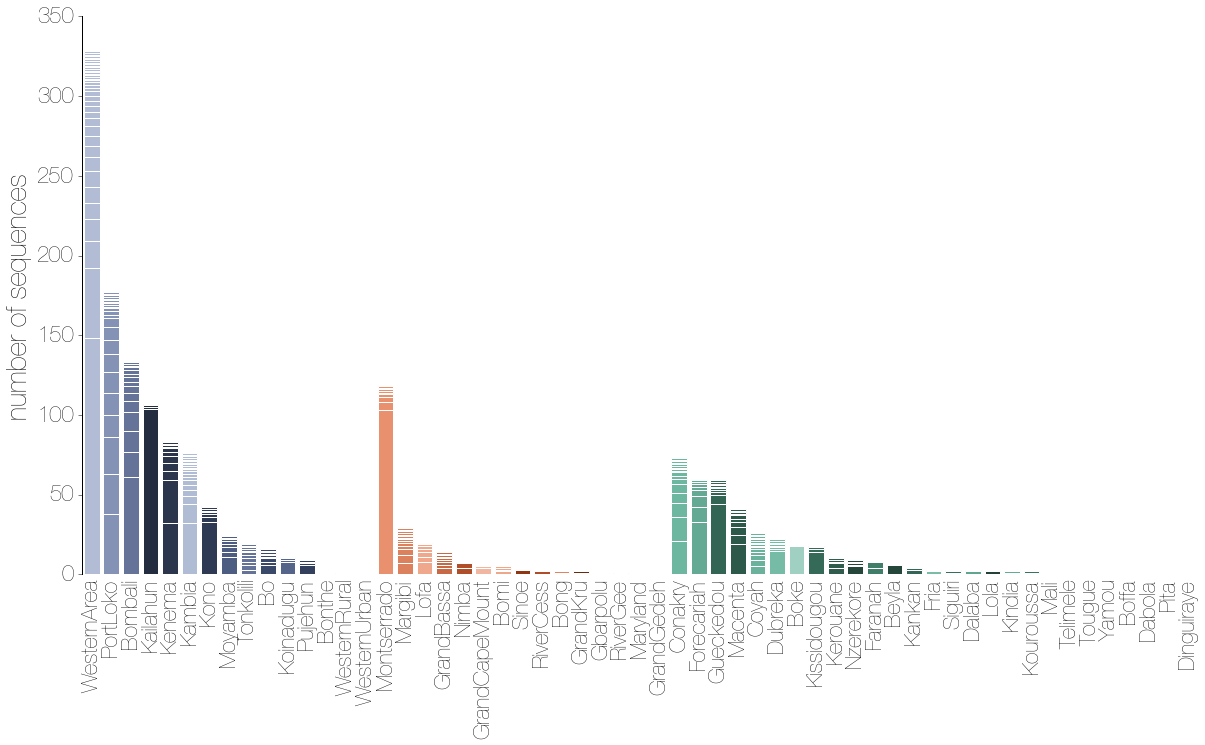

In [8]:
fig,ax = plt.subplots(figsize=(20,10),facecolor='w')

xs=sorted(subtree_sizes.keys(),key=lambda x:(location_to_country[x],np.log10(sum(subtree_sizes[x]))),reverse=True)
# xs=sorted(subtree_sizes.keys(),key=lambda x:(location_to_country[x],-sum(subtree_sizes[x])))

xs=[x for x in xs if sum(cases_byLocation[x].values())>0]

for l,loc in enumerate(xs):
    country=location_to_country[loc]
    c=colours[country](normalized_coords[loc])

    ys=sorted(subtree_sizes[loc],reverse=True)
    for y,val in enumerate(ys):
#         ax.bar(l,np.log10(val),bottom=np.log10(10.0**sum(ys[:y])),facecolor=c,edgecolor='w',lw=2,align='center')
        #print val,sum(ys[:y])
        ax.bar(l,val,bottom=sum(ys[:y]),facecolor=c,edgecolor='w',lw=1,align='center') ## plot stacked bars of introduction sizes for each location
        
ax.set_xticks(range(len(xs)))
ax.set_xticklabels(xs,rotation=90)

ax.set_xlim(-0.5,len(xs)-0.5)
ax.set_ylabel('number of sequences',size=28)

# ylabels=[tick.get_text() for tick in ax.get_yticklabels()]
# for t,tick in enumerate(ylabels):
#     ylabels[t]='10$^{%.2f}$'%(float(tick.encode('utf-8')))
#ax.set_yscale('log')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.yaxis.tick_left()

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',direction='out')
plt.show()

In [9]:
persistence_out=open(local_output+'EBOV_1610_loc_persistence.txt','w')
print>>persistence_out,'location\tclade sizes\tN introductions\tmedian persistence (days)\tmean persistence (days)\tstandard deviation\tpersistences (years)'
for loc in subtree_lengths.keys():
    L=len(subtree_lengths[loc])
    
    cS=map(str,subtree_sizes[loc])
    med=np.median(subtree_lengths[loc])*365
    mu=np.mean(subtree_lengths[loc])*365
    std=np.std(subtree_lengths[loc])
    
    if L>0:
        print loc,cS,L,med,mu,std
    print>>persistence_out,'%s\t%s\t%d\t%s\t%s\t%s\t%s'%(loc,','.join(cS),L,med,mu,std,','.join(map(str,subtree_lengths[loc])))
#     if len(subtree_lengths[loc])>0:
#         fig,ax = plt.subplots(figsize=(5,5),facecolor='w')
#         ax.hist([365*x for x in subtree_lengths[loc]],facecolor='steelblue')
#         ax.set_xlim(0,365)
#         plt.show()
persistence_out.close()

Macenta ['1', '2', '2', '1', '19', '3', '6', '1', '1', '5'] 4 162.512257247 158.544077955 0.0669403122528
Gueckedou ['44', '1', '6', '1', '1', '1', '1', '1', '1', '2'] 4 69.7712435494 198.722637169 0.72488484172
Forecariah ['4', '1', '2', '33', '9', '1', '1', '2', '7'] 3 53.3194290899 45.9973844217 0.0735939817806
Lofa ['1', '3', '8', '1', '2', '3', '2'] 4 24.5834331891 30.7955438782 0.0534150615589
WesternArea ['44', '4', '1', '10', '148', '17', '14', '10', '5', '9', '3', '6', '3', '1', '1', '1', '4', '1', '6', '2', '1', '1', '1', '1', '1', '1', '3', '2', '1', '2', '1', '7', '10', '1', '1', '1', '1', '1', '1'] 1 115.098459018 115.098459018 0.0
Nzerekore ['5', '1', '1', '1', '1'] 2 40.9876992449 40.9876992449 0.0582767945762
Kambia ['1', '2', '1', '2', '1', '2', '32', '3', '1', '12', '3', '1', '1', '5', '1', '1', '1', '1', '4', '1'] 7 24.2273390733 30.6578877036 0.0670848610635
PortLoko ['1', '14', '23', '1', '6', '9', '11', '1', '1', '1', '1', '1', '25', '2', '14', '13', '2', '8', '1'

/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


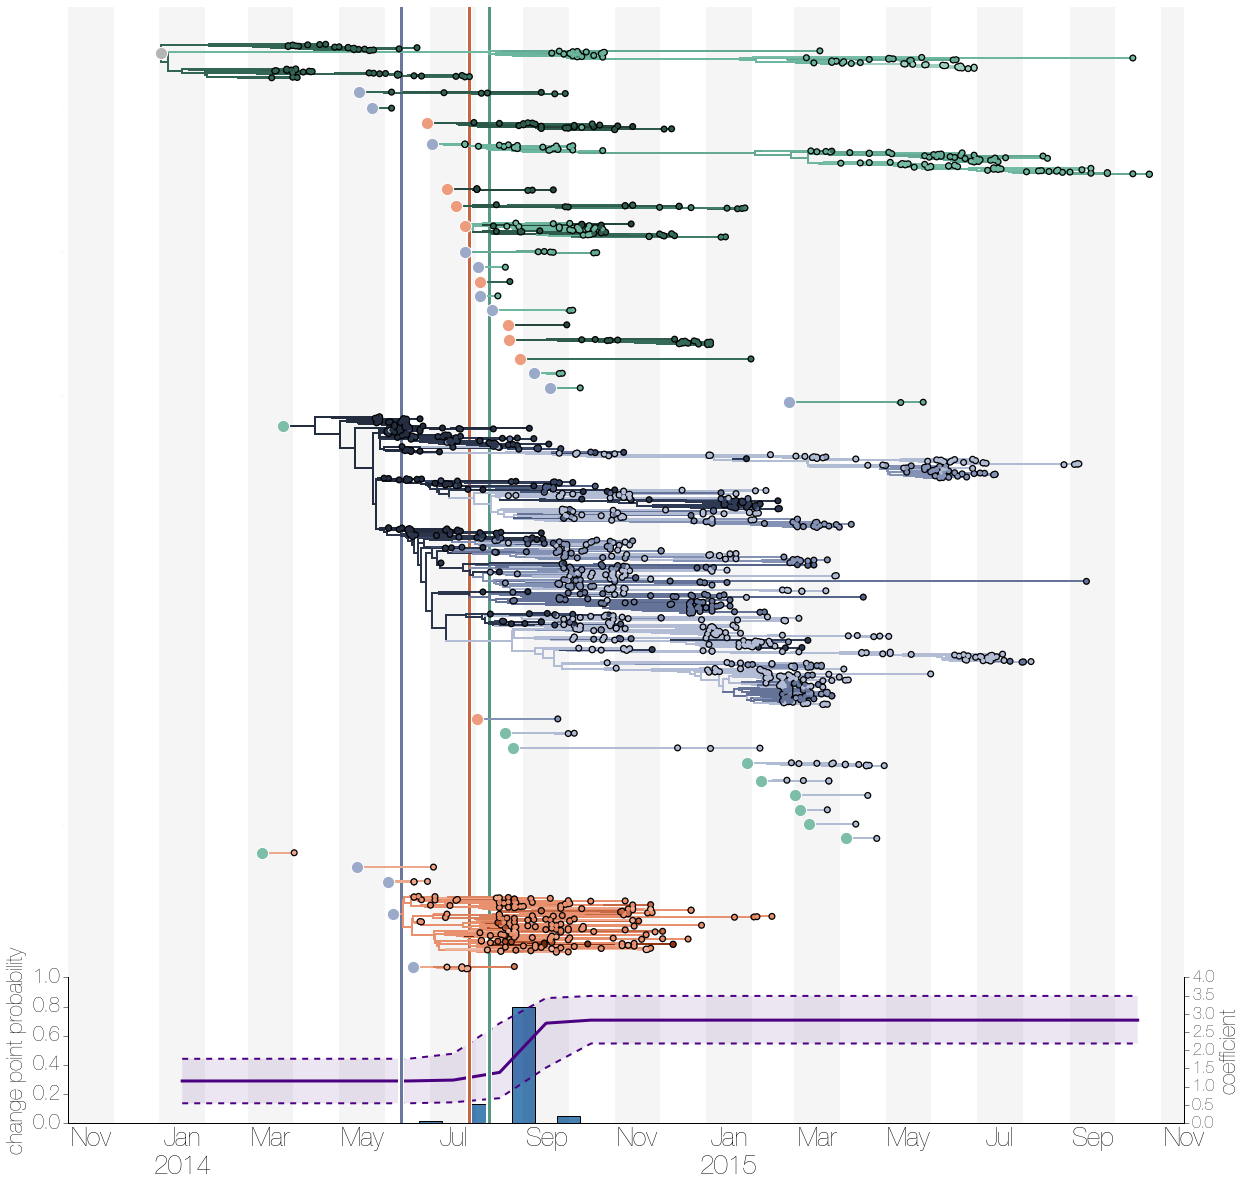

In [10]:
fig = plt.figure(figsize=(20,20),facecolor='w') ## set up whole figure
gs = gridspec.GridSpec(2, 1, height_ratios=[1,0.15],wspace=0.00,hspace=0.00) ## set up grid

# fig = plt.figure(figsize=(20,100),facecolor='w') ## for locations
# gs = gridspec.GridSpec(2, 1, height_ratios=[1,0.05],wspace=0.00,hspace=0.00) ## for locations

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1],sharex=ax)

# traitName='location'
traitName='location.states'
branchWidth=2
tipSize=20

closure_dates={'SLE':'2014-06-11','GIN':'2014-08-09','LBR':'2014-07-27'} ## border closure dates
country_order={'GIN':3,'SLE':2,'LBR':1} ## order of countries

map_to_actual['WesternArea']='Western Area'

cumulative_y=0
for country in sorted(country_trees.keys(),key=lambda x:country_order[x]): ## iterate over countries
    for t,tr in enumerate(sorted(country_trees[country],key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)))): ## iterate over subtrees within the country in order of introduction
        origin,loc_tree=tr
        
        if len([ob for ob in loc_tree.Objects if ob.branchType=='leaf'])>0: ## if there's at least one leaf in subtree
            for w in loc_tree.Objects: ## iterate over subtree branches
                location=w.traits[traitName] ## get location
                country=location_to_country[location] ## get country from location
                cmap=colours[country] ## get colour map for country
                c=cmap(normalized_coords[location]) ## get standardised colour for location

                y=w.y
                x=w.absoluteTime
                
                if y!=None:
                    if w.parent!=None:
                        xp=w.parent.absoluteTime
                        yp=w.parent.y
                    else:
                        xp=x
                        yp=y
                    
                    if isinstance(w,bt.leaf):
                        ax.scatter(x,y+cumulative_y,s=tipSize,facecolor=c,edgecolor='none',zorder=100) ## plot tip circle
                        ax.scatter(x,y+cumulative_y,s=tipSize+30,facecolor='k',edgecolor='none',zorder=99)

                    elif isinstance(w,bt.node):
                        yl=w.children[0].y
                        yr=w.children[-1].y

                        ax.plot([x,x],[yl+cumulative_y,yr+cumulative_y],color=c,lw=branchWidth,zorder=98) ## plot vertical bar
                    
                    ax.plot([x,xp],[y+cumulative_y,y+cumulative_y],color=c,lw=branchWidth,zorder=98) ## plot ancestral branch

            oriC=colours[location_to_country[origin]](0.3)
            if loc_tree.Objects[0].absoluteTime==None:
                oriX=loc_tree.Objects[0].absoluteTime
                oriY=loc_tree.Objects[0].y+cumulative_y
            else:
                oriX=loc_tree.Objects[0].parent.absoluteTime
                oriY=loc_tree.Objects[0].y+cumulative_y

            if origin!='reservoir':
                effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                 path_effects.Stroke(linewidth=0.5, foreground='black')] ## black text, white outline

#                 ax.text(oriX-7/365.0,oriY,'%s'%(map_to_actual[origin]),ha='right',va='center',size=16,path_effects=effects) ## uncomment to plot text at the beginning of the subtree to indicate its origin, only use with enough vertical space
                
            ax.scatter(oriX,oriY,150,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## circle at the base of the subtree to indicate origin
            cumulative_y+=max([x.y for x in loc_tree.Objects])+50 ## increment y position

####################    
epoch_path=path_to_dropbox+'Sequences/Jun2016_1610_genomes/GLM/epoch/changePointEstimates.csv'

xs=[]
ymu=[]
yhi=[]
ylo=[]
ps=[]

axx=ax2.twinx() ## secondary y axis

for line in open(epoch_path,'r'): ## load epoch data
    l=line.strip('\n').split(',') 
    if l[0]=='month':
        header=l
    else:
        d=decimalDate(l[0],fmt='%b-%y')
        prob,meanC,hpLo,hpHi=map(float,l[1:])
        xs.append(d)
        ps.append(prob)
        ymu.append(meanC)
        yhi.append(hpHi)
        ylo.append(hpLo)
        
ax2.bar(xs,ps,width=1/24.0,align='center',facecolor='steelblue',lw=1,edgecolor='k')
axx.plot([x+1/24.0 for x in xs],ymu,color='indigo',lw=3)
axx.fill_between([x+1/24.0 for x in xs],ylo,yhi,facecolor='indigo',edgecolor='none',alpha=0.1)
axx.plot([x+1/24.0 for x in xs],ylo,color='indigo',ls='--',alpha=1.0,lw=2)
axx.plot([x+1/24.0 for x in xs],yhi,color='indigo',ls='--',alpha=1.0,lw=2)
ax2.set_ylim(0,1)
axx.set_ylim(0,4)

ax2.spines['top'].set_visible(False)
axx.spines['top'].set_visible(False)

ax2.tick_params(axis='x',labelsize=26,size=0)
ax2.tick_params(axis='y',labelsize=20,size=5,direction='out')
axx.tick_params(axis='x',labelsize=0,size=0)
axx.tick_params(axis='y',labelsize=16,size=5,direction='out')

axx.set_ylabel('coefficient')
ax2.set_ylabel('change point probability')  

for country in required_countries: ## plot border closures in all axes
    ax2.axvline(decimalDate(closure_dates[country]),lw=3,color=colours[country](0.5),zorder=3)
    ax2.axvline(decimalDate(closure_dates[country]),lw=6,color='w',zorder=2)

    axx.axvline(decimalDate(closure_dates[country]),lw=3,color=colours[country](0.5),zorder=3)
    axx.axvline(decimalDate(closure_dates[country]),lw=6,color='w',zorder=2)

    ax.axvline(decimalDate(closure_dates[country]),lw=3,color=colours[country](0.5),zorder=3)
    ax.axvline(decimalDate(closure_dates[country]),lw=6,color='w',zorder=2)
#####################

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

every=2
xDates=['2013-%02d-01'%x for x in range(11,13)]
xDates+=['2014-%02d-01'%x for x in range(1,13)]
xDates+=['2015-%02d-01'%x for x in range(1,12)]

ax.set_xlim(decimalDate(xDates[0]),decimalDate(xDates[-1]))
ax2.set_xlim(decimalDate(xDates[0]),decimalDate(xDates[-1]))

[ax2.axvspan(decimalDate(xDates[x]),decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
[ax.axvspan(decimalDate(xDates[x]),decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%2==0])
ax2.set_xticks([decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%2==0])
axx.set_xticks([decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%2==0])

ax2.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%2==0])

# ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%2==0])
# axx.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%2==0])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',labelsize=0,size=0)
ax.tick_params(axis='y',labelsize=0,size=0)

ax.set_ylim(-30,cumulative_y+80)
# plt.savefig(local_output+'locTrees.png',dpi=200,bbox_inches='tight')
# plt.savefig(local_output+'locTrees.pdf',dpi=200,bbox_inches='tight')
# plt.savefig(local_output+'trees.png',dpi=200,bbox_inches='tight')
# plt.savefig(local_output+'trees.pdf',dpi=200,bbox_inches='tight')
plt.show()

{'Lofa': 2014.2465749041096, 'Montserrado': 2014.445248856425}
{'PortLoko': 2014.7287669041098, 'WesternArea': 2014.9190053589193, 'Kailahun': 2014.2844988524307, 'Kambia': 2014.7227849802193}
{'Siguiri': 2015.0821919041098, 'Gueckedou': 2014.0029998332136, 'Nzerekore': 2014.5738843774839, 'Conakry': 2014.5204842283774, 'Macenta': 2014.545307120637, 'Forecariah': 2014.645753344498}


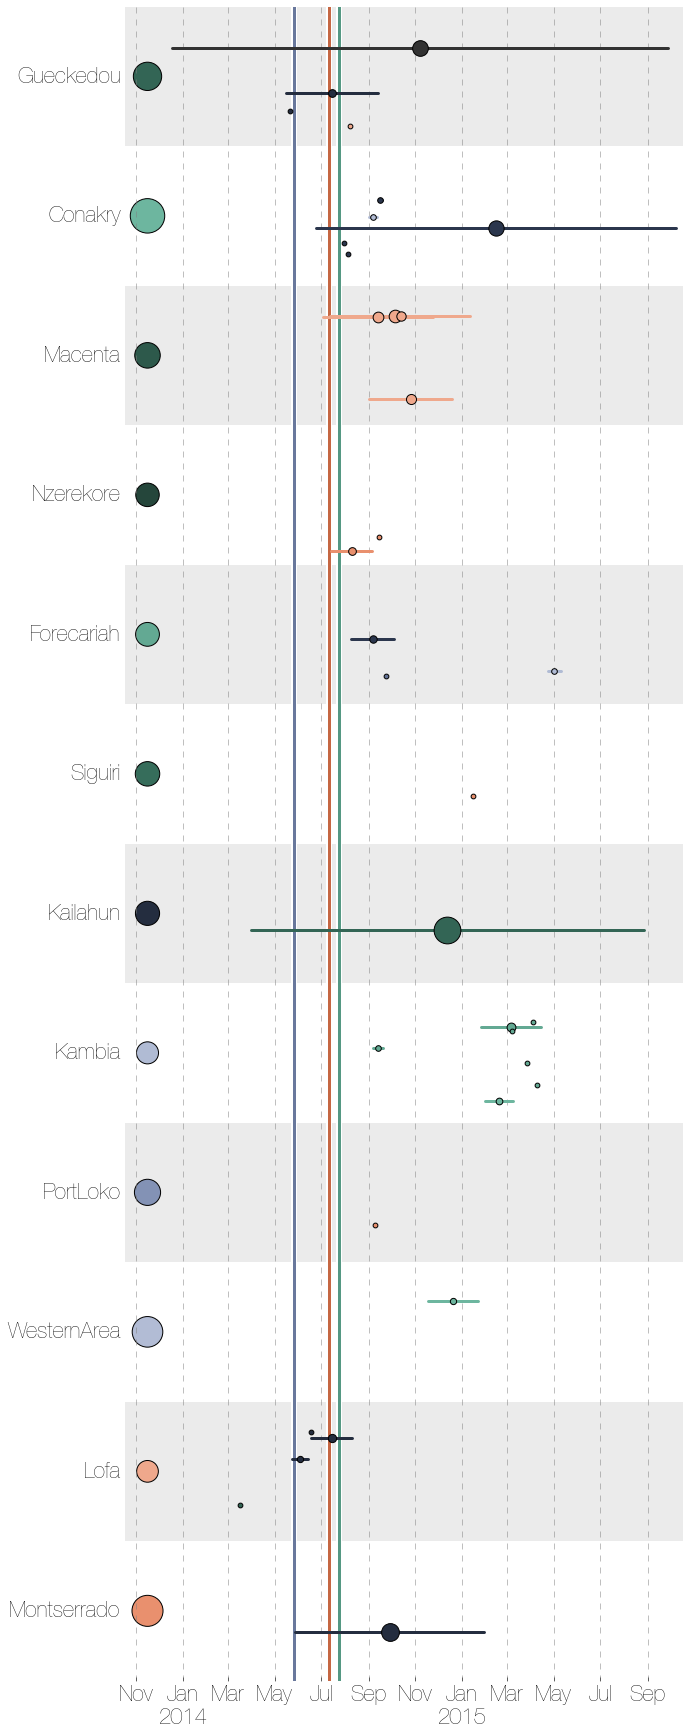

In [11]:
fig = plt.figure(figsize=(10,30),facecolor='w') ## for countries
gs = gridspec.GridSpec(1, 1,wspace=0.00,hspace=0.00) ## for countries

# fig = plt.figure(figsize=(20,100),facecolor='w') ## for locations
# gs = gridspec.GridSpec(2, 1, height_ratios=[1,0.05],wspace=0.00,hspace=0.00) ## for locations

ax = plt.subplot(gs[0])
# ax2 = plt.subplot(gs[1],sharex=ax)

# traitName='location'
traitName='location.states'
branchWidth=2
tipSize=20

closure_dates={'SLE':'2014-06-11','GIN':'2014-08-09','LBR':'2014-07-27'}
country_order={'GIN':3,'SLE':2,'LBR':1}

cumulative_y=0
storeDestination=''
ylabels=[]
for country in sorted(country_trees.keys(),key=lambda x:country_order[x]):

    earliestIntro={x[1].Objects[0].traits[traitName]:min([y[1].Objects[0].absoluteTime for y in country_trees[country] if y[1].Objects[0].traits[traitName]==x[1].Objects[0].traits[traitName]]) for x in country_trees[country]}
    print earliestIntro
    countryTree=sorted(country_trees[country],key=lambda x:(-earliestIntro[x[1].Objects[0].traits[traitName]],normalized_coords[x[1].Objects[0].traits[traitName]],x[1].Objects[0].absoluteTime))

    for t,tr in enumerate(countryTree):
        origin,loc_tree=tr
        destination=loc_tree.Objects[0].traits[traitName]
        originTime=loc_tree.Objects[0].absoluteTime
        loc_leaves=[w for w in loc_tree.Objects if w.branchType=='leaf']
        cladeSize=float(len(loc_leaves))
        countryColour=colours[location_to_country[origin]]
        c=countryColour(normalized_coords[origin])
        lastTip=max([decimalDate(w.name.split('|')[-1]) for w in loc_leaves])
        persistence=lastTip-originTime
        
        if storeDestination!=destination:
            cumulative_y+=1
            ylabels.append(destination)
            
        height=persistence/cladeSize
        scaleHeight=3.0
        ax.plot()
        
        radius=np.sqrt(cladeSize/np.pi)*40.0
        #print radius
#         ax.add_patch(plt.Circle((lastTip-radius*0.5,cumulative_y),radius=radius,fc=c,ec='k',zorder=1000-cladeSize,alpha=0.4,transform=None))
        
        jitter=np.random.uniform(-0.4,0.4)
        ax.scatter(np.mean([lastTip,originTime]),cumulative_y+jitter,s=radius,facecolor=c,edgecolor='k',zorder=10000,alpha=1.0)
        
        ax.plot([originTime,lastTip],[cumulative_y+jitter,cumulative_y+jitter],
                lw=3,alpha=1.0,color=c,zorder=10000-cladeSize-1,solid_capstyle='round')
        
        #ax.add_patch(plt.Rectangle((originTime,cumulative_y-height*0.5*scaleHeight),persistence,height*scaleHeight,
#                                         fc=c,ec='k',lw=0.5,alpha=0.7,zorder=10000-height*1000.0))
        #print origin,cladeSize,persistence
        
        storeDestination=destination
ylabels.append(destination)
        
    
popPath=open('/Users/evogytis/Dropbox/Ebolavirus_Phylogeography/Location_GLM/sparks/sparky.csv','r')
popSizes={}
for line in popPath:
    l=line.strip('\n').split(',')
    if l[0]!='location':
        popSizes[l[0]]=float(l[-2])
popSizes['WesternArea']=popSizes['WesternUrban']+popSizes['WesternRural']
    
ax.set_yticks(range(1,len(ylabels)))
ax.set_yticklabels(ylabels)

ax.scatter([decimalDate('2013-12-01') for y in range(1,len(ylabels))],range(1,len(ylabels)),s=[10+((3.0*popSizes[loc]-3.0*min(popSizes.values()))/np.pi)**0.5 for loc in ylabels],c=[colours[location_to_country[loc]](normalized_coords[loc]) for loc in ylabels])

# for tick in ax.get_yticklabels():
#     loc=tick.get_text()
#     countryColour=colours[location_to_country[loc]]
#     tick.set_color(countryColour(normalized_coords[loc]))
#     if loc=='WesternArea':
#         popSizes['WesternArea']=popSizes['WesternUrban']+popSizes['WesternRural']
#         map_to_actual['WesternArea']='Western Area'
#     fsize=10+(np.log10(popSizes[loc])-np.log10(min(popSizes.values())))*20.0
    #print fsize
    #tick.set_fontsize(fsize)

ax.tick_params(axis='y',size=0)
ax.grid(axis='x',ls='--',color='grey')

[ax.axhspan(x-0.5,x+0.5,facecolor='k',edgecolor='none',alpha=0.08,zorder=0) for x in range(0,len(ylabels)+2,2)]

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

every=2
xDates=['2013-%02d-01'%x for x in range(11,13)]
xDates+=['2014-%02d-01'%x for x in range(1,13)]
xDates+=['2015-%02d-01'%x for x in range(1,12)]

#[ax.axvspan(decimalDate(xDates[x]),decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%2==0])
ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%2==0])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_ylim(0.5,len(ylabels)-0.5)

ax.set_xlim(decimalDate(xDates[0]),decimalDate(xDates[-1]))

for country in required_countries:
    ax.axvline(decimalDate(closure_dates[country]),lw=3,color=colours[country](0.5),zorder=2)
    ax.axvline(decimalDate(closure_dates[country]),lw=6,color='w',zorder=1)

# plt.savefig(local_output+'persistences.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'persistences.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [12]:
# traitName='location'
traitName='location.states'
branchWidth=2
tipSize=30

ll.root.traits[traitName]='reservoir'
ll.root.y=0
ll.root.x=ll.Objects[0].absoluteTime

location_to_country['reservoir']='?'
normalized_coords['reservoir']=1.0

for k in ll.Objects:
    #print k.traits,k.parent.traits
    kloc=k.traits[traitName]
    kploc=k.parent.traits[traitName]
    if kploc!=kloc:
        if kploc=='reservoir':
            subtree=copy.deepcopy(ll.traverseWithinTrait(k,traitName))
            
local_tree=bt.tree() ## create a new tree object where the subtree will be
local_tree.Objects=subtree ## assign objects

local_tree.root.children.append(subtree[0]) ## connect objects with the root
subtree[0].parent=local_tree.root
local_tree.root.absoluteTime=subtree[0].absoluteTime-subtree[0].length

local_tree.sortBranches() ## sort branches (also draws tree)

local_tree.root.x=local_tree.Objects[0].x
local_tree.root.y=local_tree.Objects[0].y

N_times={x:0 for x in locations}
for q in local_tree.Objects:
    if isinstance(q,bt.node):
        toReplace=[]
        for ch,child in enumerate(q.children):
            childTrait=child.traits[traitName]
            parentTrait=q.traits[traitName]
            if childTrait!=parentTrait:
                toReplace.append(child)
                
        for child in toReplace:
            childTrait=child.traits[traitName]
            print q.index,parentTrait,childTrait
            N_times[childTrait]+=1
            q.children.remove(child)

            fake_leaf=bt.leaf()
            if N_times[childTrait]==1:
                if childTrait=='Conakry':
                    fake_leaf.name='%s (%s)\nGN-1 lineage'%(childTrait,location_to_country[childTrait])
                elif childTrait=='Kailahun':
                    fake_leaf.name='%s (%s), SL lineages'%(childTrait,location_to_country[childTrait])
                else:
                    fake_leaf.name='%s (%s)'%(childTrait,location_to_country[childTrait])
            else:
                fake_leaf.name='%s#%d (%s)'%(childTrait,N_times[childTrait],location_to_country[childTrait])
            fake_leaf.numName=fake_leaf.name
            fake_leaf.traits[traitName]=childTrait
            fake_leaf.index='%s%s%s'%(np.random.random(),np.random.random(),np.random.random()) ## generate random index
            fake_leaf.length=child.length
            fake_leaf.absoluteTime=q.absoluteTime+fake_leaf.length
            fake_leaf.height=q.height+fake_leaf.length
            
            fake_leaf.parent=q
            q.children.append(fake_leaf)
            q.leaves=[]
            q.numChildren=0
            local_tree.Objects.append(fake_leaf)
            

1 Gueckedou Conakry
115229 Gueckedou Kailahun
2103947 Gueckedou Kissidougou
96076 Gueckedou Siguiri
2112463 Gueckedou Macenta
2112464 Gueckedou Macenta
2112464 Gueckedou Macenta
2129951 Gueckedou Kissidougou
2129953 Gueckedou Macenta
2125800 Gueckedou Lofa


[('Kailahun', '0.00'), ('Yamou', '0.00'), ('Kerouane', '0.00'), ('Nzerekore', '0.00'), ('Forecariah', '0.00'), ('Coyah', '0.00'), ('Conakry', '0.00'), ('Lofa', '0.01'), ('Macenta', '0.02'), ('Gueckedou', '0.96')]


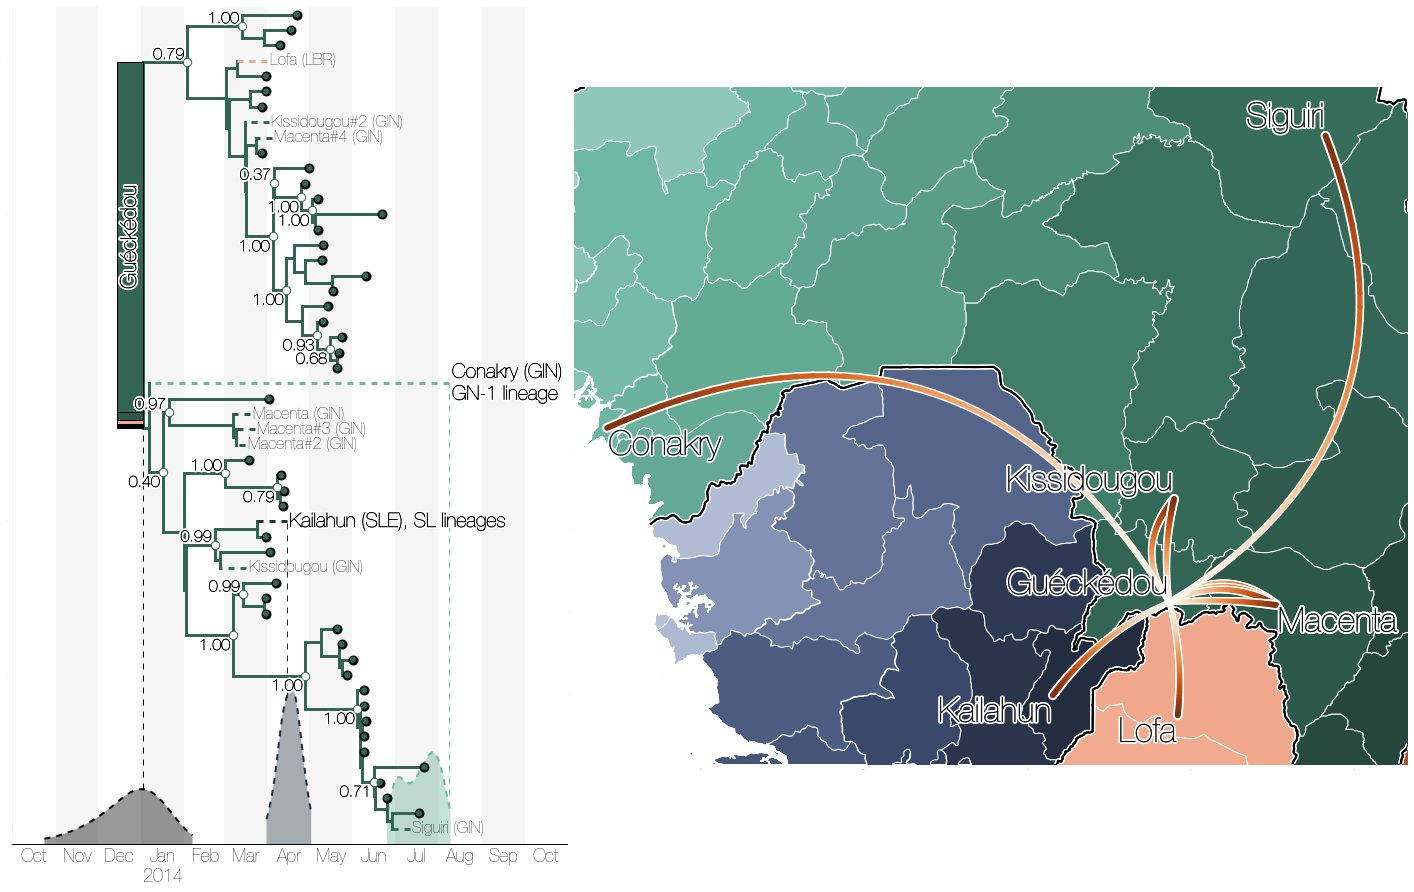

In [13]:
fig = plt.figure(figsize=(25, 15)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.5],wspace=0.01) 

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# fig,ax = plt.subplots(figsize=(10,15),facecolor='w')
tipSize=40
branchWidth=3

local_tree.traverse_tree()
local_tree.sortBranches(descending=True)
effects=[path_effects.Stroke(linewidth=4, foreground='w'),path_effects.Stroke(linewidth=0.5, foreground='k')]

for w in local_tree.Objects:
    location=w.traits[traitName]
    country=location_to_country[location]
    cmap=colours[country]
    c=cmap(normalized_coords[location])
    y=w.y
    x=w.absoluteTime

    if y!=None:
        if w.parent!=None:
            xp=w.parent.absoluteTime
            yp=w.parent.y
        else:
            xp=x
            yp=y

        if isinstance(w,bt.leaf):
            ls='-'
            if w.traits[traitName]!='Gueckedou':
                s=16
                if w.name[-1]!=')':
                    s=20
                    ax.text(x+0.005,y,'%s'%(w.name),size=s,ha='left',va='center',path_effects=effects)
                else:
                    ax.text(x+0.005,y,'%s'%(w.name),size=s,ha='left',va='center')
                ls='--'
            else:
                ax.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=100)
                ax.scatter(x,y,s=tipSize*2,facecolor='k',edgecolor='k',zorder=99)
            ax.plot([x,xp],[y,y],color=c,lw=branchWidth,ls=ls,zorder=98)
            
        elif isinstance(w,bt.node):
            yl=w.children[0].y
            yr=w.children[-1].y
            
            if w.traits['posterior']>=0.3 and len(w.leaves)>=3 and w.parent.index!='Root':
                vas=['bottom','top']
                va=vas[w.parent.children.index(w)-1]
                ax.text(x-2/365.0,y+((w.parent.children.index(w)-1)*0.2),'%.2f'%(w.traits['posterior']),va=va,ha='right',size=16,path_effects=effects,zorder=101)
                ax.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
            
            if w.parent==local_tree.root:
#                 location_states=w.traits['%s.states.set'%(traitName)]
#                 location_probs=w.traits['%s.states.set.prob'%(traitName)]
                location_states=w.traits['%s.set'%(traitName)]
                location_probs=w.traits['%s.set.prob'%(traitName)]
                join_probs={a:b for a,b in zip(location_states,location_probs)}
                sort_locations=sorted(join_probs.keys(),key=lambda a:join_probs[a])
                print [(a,'%.2f'%join_probs[a]) for a in sort_locations]
                width=0.05
                heightRange=yr-yl
                start=yl
                for loc in sort_locations:
                    height=heightRange*join_probs[loc]
                    #print loc,'%.2f'%(join_probs[loc])
                    country=location_to_country[loc]
                    fc=colours[country](normalized_coords[loc])
                    
                    if join_probs[loc]>=0.2:
                        ax.text(x-width*0.5,np.mean([start,start+height]),'%s'%(map_to_actual[loc]),rotation=90,zorder=101,va='center',ha='center',path_effects=effects)
                    ax.add_patch(plt.Rectangle((x-width,start),width,height,facecolor=fc,edgecolor='k',lw=1,zorder=100))
                    start+=height
                
            ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98)
            ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=98)

for intro in rootHeights.keys():
    hpdLo,hpdHi=hpd(rootHeights[intro],0.95)

    x_grid=np.linspace(hpdLo,hpdHi,100)
    kde=gaussian_kde(rootHeights[intro],0.3)
    y_grid=kde.evaluate(x_grid)

    root_y=[(y*0.6)-1 for y in y_grid]
    
    if intro=='Root':
        c='k'
        #intro='reservoir'
    else:
        c=colours[location_to_country[intro]](normalized_coords[intro])

    if intro!='Root':
        topX,topY=[(k.absoluteTime,k.y) for k in local_tree.Objects if k.traits[traitName]==intro][-1]
    else:
        topX,topY=local_tree.Objects[0].absoluteTime,local_tree.Objects[0].children[0].y
        
    bottomX=topX
    bottomY=(kde.evaluate(bottomX)*0.6)-1
        
    ax.plot([bottomX,topX],[bottomY,topY],ls='--',color=c)
    
    ax.fill_between(x_grid,root_y,y2=-1,facecolor=c,edgecolor='none',alpha=0.4)
    ax.plot(x_grid,root_y,lw=2,color=c,ls='--')
          

every=1
xDates=['2013-%02d-01'%x for x in range(1,13)]
xDates+=['2014-%02d-01'%x for x in range(1,12)]
# xDates+=['2015-%02d-01'%x for x in range(1,12)]


[ax.axvspan(decimalDate(xDates[x]),decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=18,size=0)

ax.set_xlim(decimalDate('2013-10-01'),decimalDate(xDates[-1]))
ax.set_ylim(-1,len(local_tree.Objects)/2.0)

for loc in locations:
    if location_to_country[loc] in required_countries:
        countryColour=colours[location_to_country[loc]]
        c=countryColour(normalized_coords[loc])
        ax2.add_collection(PatchCollection(polygons[loc],facecolor=c,edgecolor='w',lw=1,zorder=1))


normalize_height=create_normalization([x.parent.absoluteTime for x in local_tree.Objects if len(x.parent.traits)>0 and x.traits[traitName]!=x.parent.traits[traitName]],0.0,1.0)

destinationXs=[]
destinationYs=[]
destinations=['Gueckedou']
for w in local_tree.Objects:
    if len(w.parent.traits)>0:
        locA=w.traits[traitName]
        locB=w.parent.traits[traitName]
        if locA!=locB:
            destinations.append(locA)
            country=location_to_country[location]
            cmap=colours[country]
            c=cmap(normalized_coords[location])
            y=w.y
            x=w.absoluteTime

            if y!=None:
                if w.parent!=None:
                    xp=w.parent.absoluteTime
                    yp=w.parent.y
                else:
                    xp=x
                    yp=y

            end=w.height
            start=w.parent.height

            oriX,oriY=popCentres[locB]
            desX,desY=popCentres[locA]

            destinationXs.append(desX)
            destinationYs.append(desY)
            
            ## normalize time of lineage
            normalized_height=normalize_height(w.absoluteTime)
            normalized_parent_height=normalize_height(w.parent.absoluteTime)
            #print normalized_height,normalized_parent_height
            ## define Bezier curve
            distance=math.sqrt(math.pow(oriX-desX,2)+math.pow(oriY-desY,2))

            ## adjust_d is the function that determines where the Bezier line control point will be
#             adjust_d=distance-(distance**0.5)*normalized_height
            adjust_d=0.1-2*normalized_height+1/float(distance)**0.1-0.1

            ## control point coordinate set perpendicular to midway between point A and B at a distance adjust_d
            n=Bezier_control((oriX,oriY),(desX,desY),adjust_d)

            ## get Bezier line coordinates
            curve=Bezier([(oriX,oriY),n,(desX,desY)],0.0,1.0,num=40)

            midpoint=np.mean([normalized_parent_height,normalized_height])

            ## iterate through Bezier curve coordinates, alter colour according to height
            for i in range(len(curve)-1):
                x1,y1=curve[i]
                x2,y2=curve[i+1]
                frac=(i/float(len(curve)))

                ax2.plot([x1,x2],[y1,y2],lw=4+2*frac,color=desaturate(mpl.cm.Oranges(frac),0.8),
                         zorder=int(normalized_height*10000),solid_capstyle='round')
                ax2.plot([x1,x2],[y1,y2],lw=6+4*frac,color='w',zorder=int(normalized_height*10000)-1,solid_capstyle='round')
        
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.tick_params(labelsize=0,size=0)

## identify the longest axis
frameLength=max([max(destinationXs)-min(destinationXs),max(destinationYs)-min(destinationYs)])

for loc in destinations:
    ## define available text alignments and corrections for text positions
    vas=['bottom','top']
    has=['left','right']
    corrections=[0.01,-0.01]

    ## set default text alignment (right, top)
    h=1
    v=1
    ## check if custom text positions are available
    if textCorrection.has_key(loc):
        if loc=='Kissidougou' or loc=='Siguiri' or loc=='Gueckedou':
            h=1
            v=0
        elif loc=='Conakry':
            h=0
            v=1
        elif loc=='Macenta':
            h=0
            v=1
#         elif loc=='Kailahun':
#             h=1
#             v=1
#         h,v=textCorrection[loc]

    effects=[path_effects.Stroke(linewidth=4, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')]
    
    lon,lat=popCentres[loc]
    ## plot district names at population centres, with corrections so as not to obscure it
    ax2.text(lon+corrections[h],lat+corrections[v]*1.5,r'%s'%map_to_actual[loc],size=34,
             va=vas[v],ha=has[h],alpha=1.0,path_effects=effects,zorder=100000)


ax2.set_xlim(min(destinationXs)-0.2,max(destinationXs)+0.5)
ax2.set_ylim(min(destinationYs)-0.3,max(destinationYs)+0.3)
ax2.set_aspect(1)

for l,local_border in enumerate(global_border):
    ax2.plot(column(local_border,0),column(local_border,1),lw=2,color='k',zorder=97,label='%d_border'%(l))
    ax2.plot(column(local_border,0),column(local_border,1),lw=5,color='w',zorder=96)

# plt.savefig(local_output+'InitialStages.png',dpi=200,bbox_inches='tight')
# plt.savefig(local_output+'InitialStages.pdf',dpi=200,bbox_inches='tight')

plt.show()

1 1005
50%: 23.20 95%: 46.95


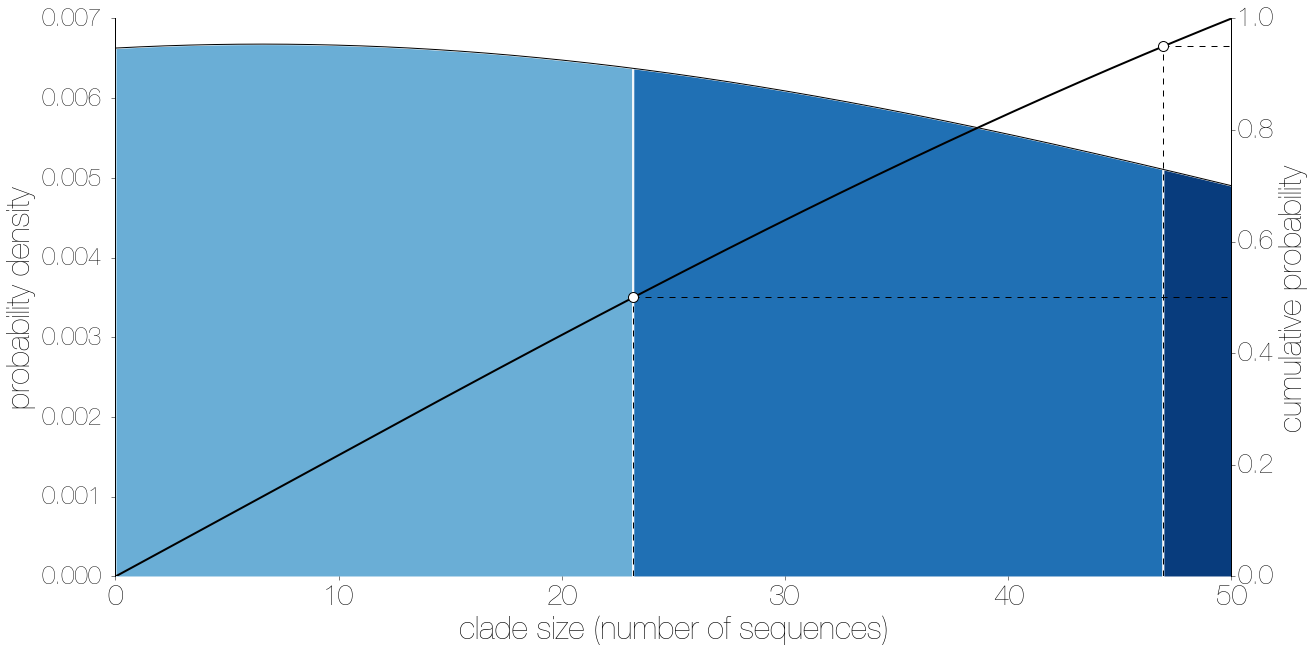

-3.69863073502e-07 1.77782208459
50%: 0.17 95%: 0.61


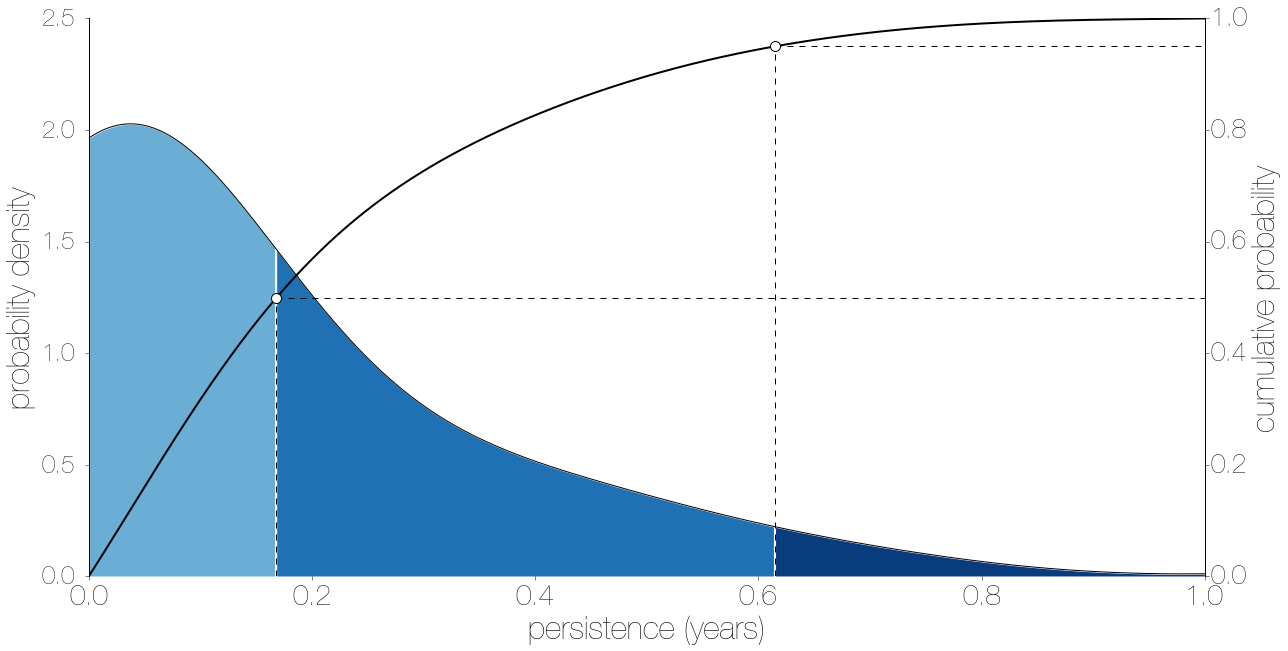

1 7
50%: 2.61 95%: 6.88


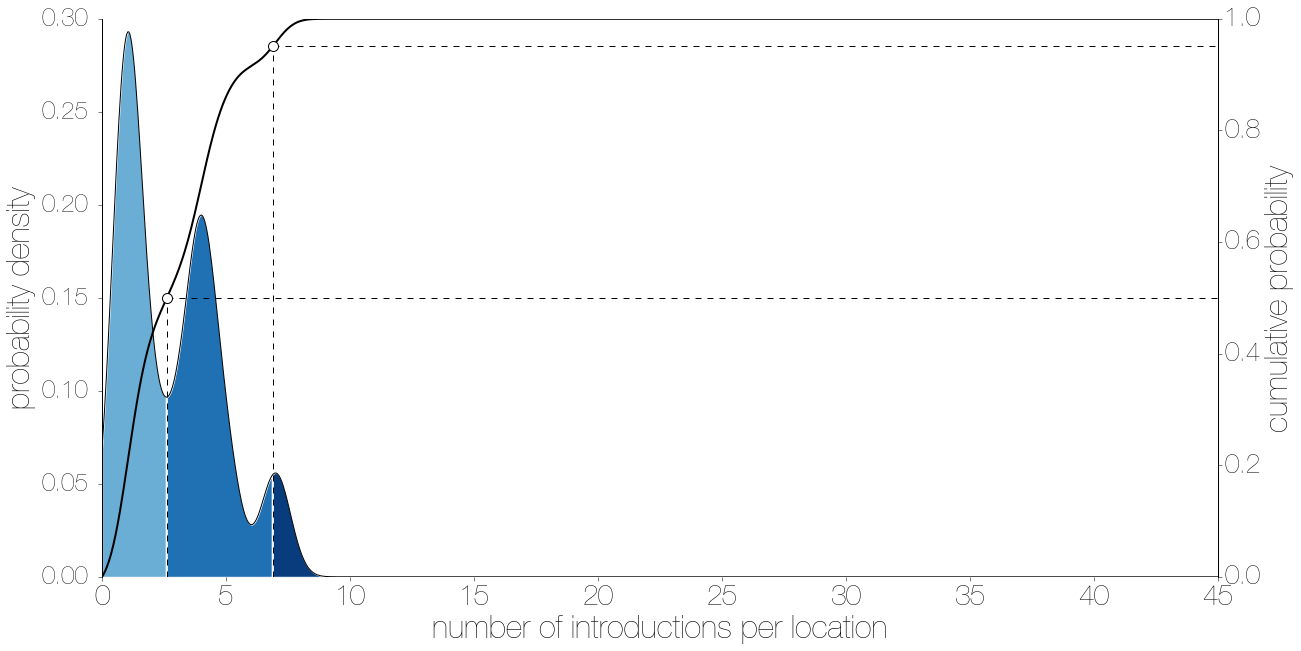

In [14]:
unroll_trees=[]

persistences=[]
cladeSizes=[]
introductions=[]
for country in country_trees.keys():
    unroll_trees+=[tr[-1] for tr in country_trees[country]]
    
    persistences+=[max([bt.decimalDate(tip.name.split('|')[-1]) for tip in tr[-1].Objects if tip.branchType=='leaf'])-tr[-1].Objects[0].absoluteTime for tr in country_trees[country]]
    
    cladeSizes+=[len(tr[-1].Objects[0].leaves) if tr[-1].Objects[0].branchType=='node' else 1 for tr in country_trees[country]]

    introductions+=[tr[-1].Objects[0].traits[traitName] for tr in country_trees[country]]
    
# print cladeSizes
#print persistences
introductions=[introductions.count(loc) for loc in unique(introductions)]


for data in [cladeSizes,persistences,introductions]:
    print min(data),max(data)
    cmap=mpl.cm.Blues
    if min(data)==1 and max(data)>100:
        x_grid=np.linspace(0.0,50.0,1001)
        #cmap=mpl.cm.inferno
#         ax2.set_xlabel('clade size (number of sequences)',size=32)
    elif min(data)==1 and max(data)<50:
        x_grid=np.linspace(0.0,45.0,1001)
        #cmap=mpl.cm.viridis
    elif min(data)<0.00001:
        x_grid=np.linspace(0.0,1.0,1001)
        #cmap=mpl.cm.magma
#         ax2.set_xlabel('persistence (years)',size=32)
        
    kde=gaussian_kde(data,bw_method=0.3)
    y_grid=kde.evaluate(x_grid)
    
    asymptote=kde.integrate_box_1d(0.0,max(x_grid)) ## due to high bandwidth of KDE it's necessary to renormalize the integral
    integral=[kde.integrate_box_1d(0.0,x)/asymptote for x in x_grid] ## get normalized integral


    fig,ax = plt.subplots(figsize=(20,10),facecolor='w')

    ax.plot(x_grid,y_grid,color='k') ## plot 
    ax2=ax.twinx()

    X_grid=np.linspace(min(x_grid),max(x_grid),len(integral))
    ax2.plot(X_grid,integral,lw=2,color='k',ls='-') ## plot integral

    closestTo50=sorted(integral,key=lambda x:abs(x-0.5))[0]
    idx50=integral.index(closestTo50)

    closestTo95=sorted(integral,key=lambda x:abs(x-0.95))[0]
    idx95=integral.index(closestTo95)

    print '50%%: %.2f 95%%: %.2f'%(x_grid[idx50],x_grid[idx95])

    al=0.5
    
    ax2.plot([x_grid[idx50],x_grid[idx50]],[0.0,integral[idx50]],ls='--',color='k')
    ax2.plot([x_grid[idx50],max(x_grid)],[integral[idx50],integral[idx50]],ls='--',color='k')

    ax2.plot([x_grid[idx95],x_grid[idx95]],[0.0,integral[idx95]],ls='--',color='k')
    ax2.plot([x_grid[idx95],max(x_grid)],[integral[idx95],integral[idx95]],ls='--',color='k')

    ax2.scatter(x_grid[idx95],integral[idx95],s=100,zorder=3,facecolor='w')
    ax2.scatter(x_grid[idx50],integral[idx50],s=100,zorder=3,facecolor='w')


###    #ax.plot([x_grid[idx50],x_grid[idx50]],[0.0,y_grid[idx50]],zorder=1)
####     ax.fill_between(x_grid[:idx50],y_grid[:idx50],alpha=al,facecolor='grey',edgecolor='k',zorder=1)
####     ax.fill_between(x_grid[:idx95],y_grid[:idx95],alpha=al,facecolor='grey',edgecolor='k',zorder=0)

    ax.fill_between(x_grid[:idx50],y_grid[:idx50],facecolor=cmap(0.5),edgecolor='w',lw=1)
    ax.fill_between(x_grid[idx50:idx95],y_grid[idx50:idx95],facecolor=cmap(0.75),edgecolor='w',lw=1)
    ax.fill_between(x_grid[idx95:],y_grid[idx95:],facecolor=cmap(0.95),edgecolor='w',lw=1)

    ax.tick_params(axis='x',labelsize=28,direction='out',pad=-20)
    ax.tick_params(axis='y',labelsize=24,direction='out',pad=-10)
    ax2.tick_params(axis='y',labelsize=26,direction='out',pad=-20)
    
    ax.yaxis.tick_left()
    ax2.yaxis.tick_right()

    ax.xaxis.tick_bottom()
    ax2.xaxis.tick_bottom()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)

    # # ax.set_xlabel('distance (km)',size=32)
    ax.set_ylabel('probability density',size=32)
    ax2.set_ylabel('cumulative probability',size=32)
    
    if min(data)==1 and max(data)>100:
        ax.set_xlabel('clade size (number of sequences)',size=32)
    elif min(data)==1 and max(data)<50:
        ax.set_xlabel('number of introductions per location',size=32)
    elif min(data)<0.00001:
        ax.set_xlabel('persistence (years)',size=32)
    
    
    ax2.set_ylim(0.0,1.0)
    ax.set_xlim(left=0.0)

    # # plt.savefig(local_output+'kernel.png',dpi=300,bbox_inches='tight')
    # # plt.savefig(local_output+'kernel.pdf',dpi=300,bbox_inches='tight')

    plt.show()

In [15]:
output_frags=open(local_output+'treeFrags.txt','w')

for country in required_countries:
    useful_trees=[x for x in tree_strings[country] if x.count(',')>1]
    cerberus=re.findall('\'EBOV[A-Za-z0-9\.\_\|\-\?]+\|([0-9\-]+)\'',','.join(useful_trees))
    print>>output_frags,'%s\t%.4f'%(country,max(map(decimalDate,cerberus))-2013.9)

for country in required_countries:
    useful_trees=[x for x in tree_strings[country] if x.count(',')>1]
    print>>output_frags, '\n\n\n'
    for e,tstring in enumerate(useful_trees):
        outstring='\t<newick id="%s_Tree_%d">\n\t\t\t%s\n\t</newick>'%(country,e+1,tstring)
        print>>output_frags,'%s'%(outstring)
        
        
for country in required_countries:
    print>>output_frags, '\n\n\n'
    useful_trees=[x for x in tree_strings[country] if x.count(',')>1]
    for e,tstring in enumerate(useful_trees):
        print>>output_frags, '\t<treeModel id="%s_%d.treeModel">'%(country,e+1)
        print>>output_frags, '\t\t<newick idref="%s_Tree_%d"/>'%(country,e+1)
        print>>output_frags, '\t\t<rootHeight>\n\t\t\t<parameter id="%s_%d.rootHeight"/>\n\t\t</rootHeight>'%(country,e+1)
        print>>output_frags, '\t\t<nodeHeights internalNodes="true">\n\t\t\t<parameter id="%s_%d.internalNodeHeights"/>\n\t\t</nodeHeights>'%(country,e+1)
        print>>output_frags, '\t\t<nodeHeights internalNodes="true" rootNode="true">\n\t\t\t<parameter id="%s_%d.allInternalNodeHeights"/>\n\t\t</nodeHeights>'%(country,e+1)
        print>>output_frags, '\t</treeModel>'

for country in required_countries:
    print>>output_frags, '\n\n\n'
    useful_trees=[x for x in tree_strings[country] if x.count(',')>1]
    for e,tstring in enumerate(useful_trees):
        print>>output_frags, '\t\t\t<treeModel idref="%s_%d.treeModel"/>'%(country,e+1)
output_frags.close()
print 'Done!'

Done!
